In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
import math
import time

## Parámetros del sistema y configuración de simulación

In [3]:
# Áreas de la sección transversal de los tanques [cm^2]
A1, A3 = 28.0, 28.0
A2, A4 = 32.0, 32.0

# Áreas de los orificios de salida [cm^2]
a1, a3 = 0.071, 0.071
a2, a4 = 0.057, 0.057

# Constantes de flujo de las bombas [cm^3/Vs]
k1, k2 = 3.33, 3.35

# Parámetros de división de flujo entre tanques superiores e inferiores
gamma1, gamma2 = 0.70, 0.60

# Aceleración de la gravedad constante [cm/s^2]
g = 981.0

# Configuración del tiempo y paso de integración
dt = 0.05
T_sim = 5000
t = np.arange(0, T_sim + dt, dt)
n = len(t)

# Condiciones iniciales para los niveles de los cuatro tanques [cm]
h0 = np.array([12.4, 12.7, 1.8, 1.4])

# Desviación estándar del ruido gaussiano para entradas y salidas
noise_input_std = 0.1
noise_output_std = 0.1

# Duración de los escalones para la señal de excitación
t_cambio_min = 50
t_cambio_max = 50

# Límites de operación de voltaje para las bombas de agua
V_min = 0.0
V_max = 6.0

## Función del sistema dinámico no lineal de cuatro tanques

El sistema se describe mediante el siguiente conjunto de ecuaciones acopladas:

$$\frac{dh_1}{dt} = -\frac{a_1}{A_1} \sqrt{2gh_1} + \frac{a_3}{A_1} \sqrt{2gh_3} + \frac{\gamma_1 k_1}{A_1} v_1$$
$$\frac{dh_2}{dt} = -\frac{a_2}{A_2} \sqrt{2gh_2} + \frac{a_4}{A_2} \sqrt{2gh_4} + \frac{\gamma_2 k_2}{A_2} v_2$$
$$\frac{dh_3}{dt} = -\frac{a_3}{A_3} \sqrt{2gh_3} + \frac{(1 - \gamma_2) k_2}{A_3} v_2$$
$$\frac{dh_4}{dt} = -\frac{a_4}{A_4} \sqrt{2gh_4} + \frac{(1 - \gamma_1) k_1}{A_4} v_1$$


In [4]:
def nonlinear_ode_system_model(t, h, u_func, A1, A2, A3, A4, a1, a2, a3, a4, g, k1, k2, gamma1, gamma2):
    # Desempaquetado de niveles de los cuatro tanques
    h1, h2, h3, h4 = h
    eps = 1e-6

    # Protección numérica para evitar raíces cuadradas de valores negativos
    h_seguro = np.maximum(h, eps)
    h1_s, h2_s, h3_s, h4_s = h_seguro

    # Obtención de voltajes de entrada en el tiempo t
    v1, v2 = u_func(t)

    # Balance de masa para tanques inferiores con aporte de tanques superiores
    dh1dt = -(a1 / A1) * np.sqrt(2 * g * h1_s) + (a3 / A1) * np.sqrt(2 * g * h3_s) + (gamma1 * k1 / A1) * v1
    dh2dt = -(a2 / A2) * np.sqrt(2 * g * h2_s) + (a4 / A2) * np.sqrt(2 * g * h4_s) + (gamma2 * k2 / A2) * v2

    # Balance de masa para tanques superiores alimentados por flujo dividido
    dh3dt = -(a3 / A3) * np.sqrt(2 * g * h3_s) + ((1 - gamma2) * k2 / A3) * v2
    dh4dt = -(a4 / A4) * np.sqrt(2 * g * h4_s) + ((1 - gamma1) * k1 / A4) * v1

    # Retorno de las derivadas de estado para el integrador
    return [dh1dt, dh2dt, dh3dt, dh4dt]

## Creación de señales PBRS de entrada

In [5]:
# Configuración del generador de números aleatorios con semilla fija
seed_stream = 100
rng_stream = np.random.Generator(np.random.MT19937(seed_stream))

# Inicialización de índices para los cambios de nivel en la señal
t_cambio_indices = []
curr_idx = 0

# Generación de intervalos de duración aleatoria para los escalones
while curr_idx < n:
    t_cambio_indices.append(curr_idx)

    # Cálculo de la duración del escalón en segundos y su equivalente en pasos
    duracion_seg = rng_stream.uniform(t_cambio_min, t_cambio_max)
    pasos_escalon = int(duracion_seg / dt)
    curr_idx += pasos_escalon

# Generación de amplitudes aleatorias para los voltajes de ambas bombas
valores_escalones = rng_stream.uniform(V_min, V_max, size=(len(t_cambio_indices), 2))

## Construcción de la señal de entrada y adición de ruido

La señal de entrada final se modela como:
$$u_{real}(t) = \text{sat}_{V_{min}}^{V_{max}} \{ u_{ideal}(t) + \eta_u(t) \}$$

In [6]:
# Inicialización de la matriz para la señal de entrada sin perturbaciones
u_ideal = np.zeros((n, 2))

# Construcción de la señal constante a trozos basada en los índices de cambio
for i in range(len(t_cambio_indices)):
    idx_start = t_cambio_indices[i]

    # Definición del límite superior del intervalo actual
    if i == len(t_cambio_indices) - 1:
        idx_end = n
    else:
        idx_end = t_cambio_indices[i+1]

    # Asignación de voltajes v1 y v2 para el segmento de tiempo definido
    u_ideal[idx_start:idx_end, :] = valores_escalones[i]

# Generación de ruido blanco gaussiano para simular incertidumbre en actuadores
ruido_input = noise_input_std * rng_stream.standard_normal(size=u_ideal.shape)

# Aplicación de ruido y restricción de la señal a los límites físicos de operación
u_ruidosa = u_ideal + ruido_input
u_ruidosa = np.clip(u_ruidosa, V_min, V_max)

## Simulación del sistema mediante integración numérica

In [7]:
# Creación de función de interpolación para la entrada ruidosa
u_fun = interp1d(t, u_ruidosa, axis=0, kind='linear', fill_value='extrapolate')

# Definición del wrapper para integrar el modelo con parámetros fijos
ode_wrapper = lambda tt, hh: nonlinear_ode_system_model(
    tt, hh, u_fun,
    A1, A2, A3, A4,
    a1, a2, a3, a4,
    g, k1, k2, gamma1, gamma2
)

# Resolución del sistema de ecuaciones diferenciales mediante RK45
sol = solve_ivp(
    fun=ode_wrapper,
    t_span=[t[0], t[-1]],
    y0=h0,
    method='RK45',
    t_eval=t,
    rtol=1e-6,
    atol=1e-8
)

# Extracción y organización de las trayectorias de nivel simuladas
h_out = sol.y.T
h1_sim, h2_sim, h3_sim, h4_sim = h_out[:, 0], h_out[:, 1], h_out[:, 2], h_out[:, 3]
t_out = sol.t

## Adicción de ruido gaussiano a la simulación del sistema

In [8]:
# Generación de ruido blanco gaussiano para los sensores de los cuatro tanques
ruido_h1 = noise_output_std * rng_stream.standard_normal(size=h1_sim.shape)
ruido_h2 = noise_output_std * rng_stream.standard_normal(size=h2_sim.shape)
ruido_h3 = noise_output_std * rng_stream.standard_normal(size=h3_sim.shape)
ruido_h4 = noise_output_std * rng_stream.standard_normal(size=h4_sim.shape)

# Aplicación de ruido a niveles simulados con restricción de límite físico inferior
h1_ruidosa = np.maximum(h1_sim + ruido_h1, 0.0)
h2_ruidosa = np.maximum(h2_sim + ruido_h2, 0.0)
h3_ruidosa = np.maximum(h3_sim + ruido_h3, 0.0)
h4_ruidosa = np.maximum(h4_sim + ruido_h4, 0.0)

# Consolidación de vectores temporales, entradas ruidosas y niveles medidos
t_full = t_out
u_full = u_ruidosa
h1_full = h1_ruidosa
h2_full = h2_ruidosa
h3_full = h3_ruidosa
h4_full = h4_ruidosa

# Definición de la dimensión total del conjunto de datos de entrenamiento
N_TOTAL = t_full.shape[0]

## Visualización de simulación del sistema de cuatro tanques

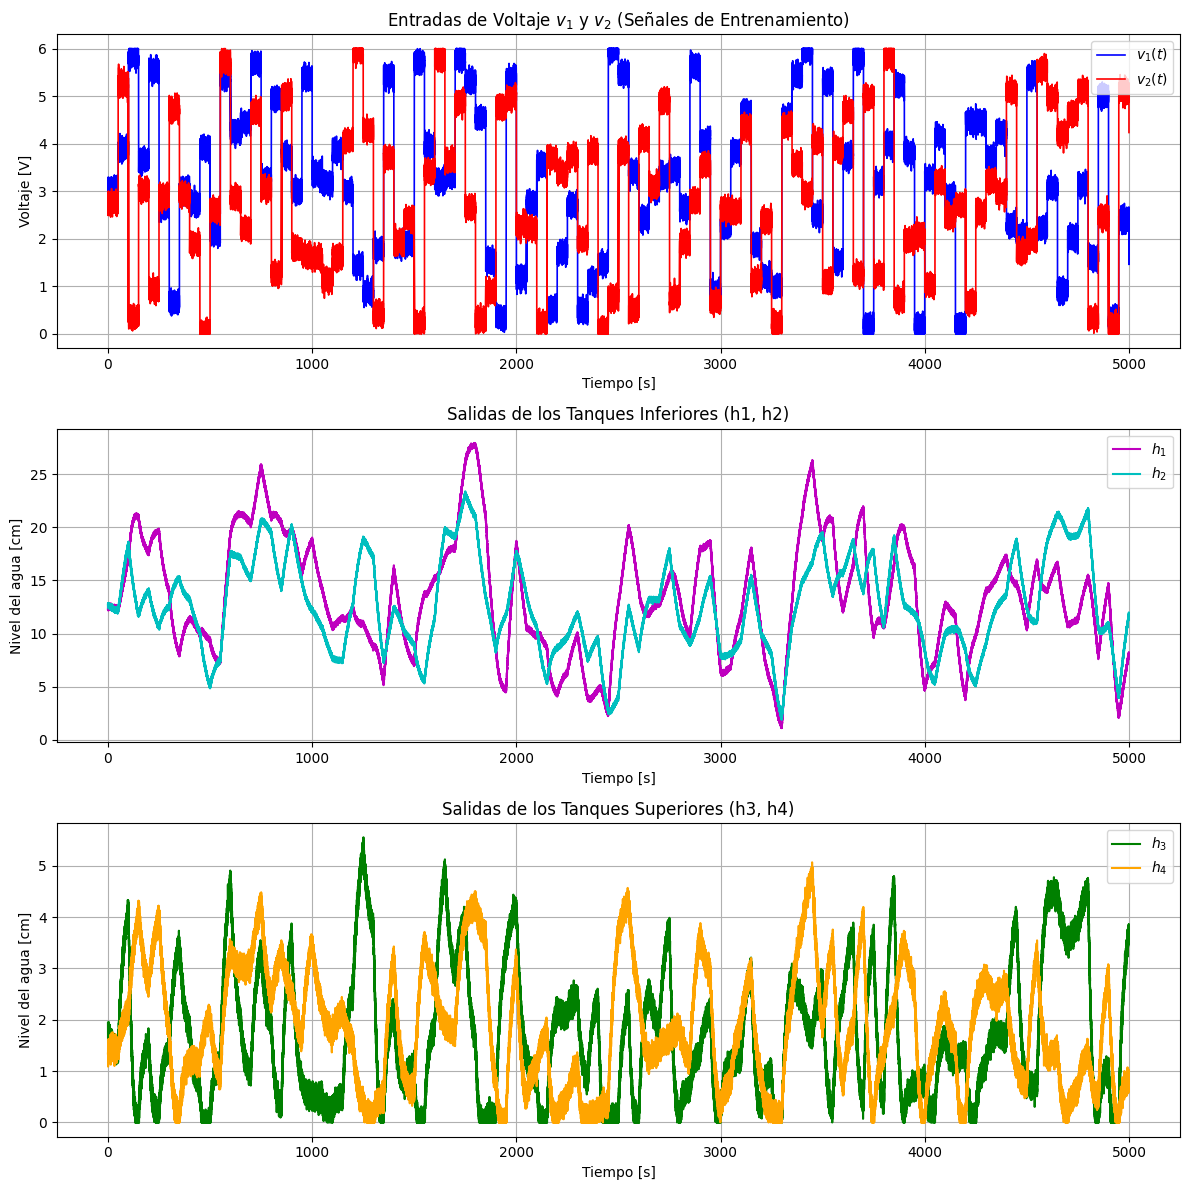

In [9]:
# Creación del lienzo para la visualización de señales de entrenamiento
plt.figure(figsize=(12, 12))

# Visualización de los voltajes de entrada aplicados a las bombas
plt.subplot(3, 1, 1)
plt.plot(t_full, u_full[:, 0], 'b', linewidth=1.2, label='$v_1(t)$')
plt.plot(t_full, u_full[:, 1], 'r', linewidth=1.2, label='$v_2(t)$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title('Entradas de Voltaje $v_1$ y $v_2$ (Señales de Entrenamiento)')
plt.legend(loc='upper right')
plt.grid(True)

# Visualización de la respuesta dinámica de los tanques inferiores
plt.subplot(3, 1, 2)
plt.plot(t_full, h1_full, 'm', linewidth=1.5, label='$h_1$')
plt.plot(t_full, h2_full, 'c', linewidth=1.5, label='$h_2$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Salidas de los Tanques Inferiores (h1, h2)')
plt.legend(loc='upper right')
plt.grid(True)

# Visualización de la respuesta dinámica de los tanques superiores
plt.subplot(3, 1, 3)
plt.plot(t_full, h3_full, 'g', linewidth=1.5, label='$h_3$')
plt.plot(t_full, h4_full, 'orange', linewidth=1.5, label='$h_4$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Salidas de los Tanques Superiores (h3, h4)')
plt.legend(loc='upper right')
plt.grid(True)

# Ajuste de disposición y despliegue de las subgráficas
plt.tight_layout()
plt.show()

## Preprocesamiento, normalización y división de datos

In [10]:
# Empaquetado de los estados (niveles) y entradas (voltajes) de la planta
X = np.array([h1_full, h2_full, h3_full, h4_full])
U = u_full.T

# Extracción de dimensiones y limpieza de estados para estabilidad numérica
dt = t_full[1] - t_full[0]
nx, nu = X.shape[0], U.shape[0]
N = X.shape[1]
X = np.maximum(X, 1e-6)

# Normalización de señales al rango [0, 1] basada en valores máximos
X_max = np.max(X, axis=1, keepdims=True)
U_max = np.max(U, axis=1, keepdims=True).clip(min=1e-6)
X_norm, U_norm = X / X_max, U / U_max

# Definición de la proporción para la división de datos de entrenamiento
train_ratio = 0.8
N_train = int(np.round(N * train_ratio))
N_val = N - N_train

# Segmentación del conjunto de datos para la fase de entrenamiento
X_train = X_norm[:, :N_train]
U_train = U_norm[:, :N_train]
t_train = t_full[:N_train]

# Segmentación del conjunto de datos para la fase de validación
X_val = X_norm[:, N_train:]
U_val = U_norm[:, N_train:]
t_val = t_full[N_train:]

## Diccionario de Observables

El éxito de la identificación mediante **EDMD** radica en la elección del diccionario de funciones no lineales $\Psi(x, u)$. Esta pieza implementa la función de "levantamiento" (*lifting*), proyectando el estado original de dimensión 4 a un espacio de mayor dimensión ($N_{obs} = 18$) donde la dinámica no lineal puede aproximarse mediante un operador lineal.

El vector de observables expandido se define como:

$$\Psi(x, u) = \begin{bmatrix} h \\ u \\ \sqrt{h} \\ h^2 \\ v \cdot \sqrt{h}_{int} \end{bmatrix} \in \mathbb{R}^{18}$$

La estructura del diccionario incluye:
1. **Identidad ($h$):** Mantiene la información del estado original (4 términos).
2. **Entradas ($v_1, v_2$):** Permite modelar la influencia directa del control (2 términos).
3. **Términos de Torricelli ($\sqrt{h}$):** Capturan la física del vaciado gravitacional (4 términos).
4. **Términos Cuadráticos ($h^2$):** Proporcionan flexibilidad para aproximar no-linealidades de segundo orden (4 términos).
5. **Interacciones de Control ($v \cdot \sqrt{h}$):** Modelan cómo el flujo de entrada es modulado por la presión hidrostática, incluyendo acoplamientos directos y cruzados entre tanques (4 términos).


In [11]:
def get_observables(x_mat, u_mat):
    # Asegura valores positivos para cálculos de raíz cuadrada y potencias
    x_safe = np.maximum(x_mat, 1e-6)
    sqrt_h = np.sqrt(x_safe)
    h_sq = x_safe**2

    # Segmentación de voltajes para el cálculo de interacciones
    v1 = u_mat[0:1, :]
    v2 = u_mat[1:2, :]

    # Construcción del vector de observables (18 términos en total)
    return np.vstack([
        x_safe, v1, v2, sqrt_h, h_sq,
        v1 * sqrt_h[0:1, :], v2 * sqrt_h[1:2, :], # Interacciones directas (bomba-tanque)
        v1 * sqrt_h[3:4, :], v2 * sqrt_h[2:3, :]  # Acoplamientos cruzados entre tanques
    ])

# Transformación de los datos de entrenamiento al espacio de Koopman
Psi_train = get_observables(X_train, U_train)
nobs = Psi_train.shape[0]
print(f"🚀 Diccionario expandido con {nobs} observables.")

🚀 Diccionario expandido con 18 observables.


## Identificación del operador Koopman incremental ($K_{\delta}$)

El proceso se fundamenta en tres pilares matemáticos:

1. **Filtrado de Savitzky-Golay:** Para evitar que el cálculo de las derivadas sea dominado por el ruido blanco, se aplica un filtro de suavizado polinomial.

2. **Formulación Incremental:** En lugar de aproximar el estado siguiente ($x_{k+1} \approx K \Psi_k$), el modelo identifica el cambio o diferencial de estado ($\Delta x$). Esto mejora significativamente el condicionamiento numérico y la estabilidad a largo plazo:
   $$\Delta x_k = x_{k+1} - x_k \approx K_{\delta} \Psi(x_k, u_k)$$

3. **Regresión Ridge (Tikhonov):** Se resuelve el problema de mínimos cuadrados con una penalización L2 ($\lambda$) para evitar el sobreajuste (*overfitting*) a los términos no lineales ($h^2$) y asegurar que la matriz $K_{\delta}$ sea generalizable:
   $$K_{\delta} = \arg \min_{K} \| \Delta X - K \Psi \|_F^2 + \lambda \| K \|_F^2$$
   $$K_{\delta} = (\Delta X \Psi^T) (\Psi \Psi^T + \lambda I)^{-1}$$

Este operador resultante $K_{\delta} \in \mathbb{R}^{4 \times 18}$ encapsula toda la dinámica lineal y no lineal del sistema de cuatro tanques.

In [12]:
# Definición de la matriz de estados actuales (instante k) a partir de datos crudos
# Usamos directamente Psi_train en lugar de Psi_smoothed
Psi_x_train = Psi_train[:, :-1]

# Cálculo del diferencial de estado real (instante k+1 - k)
# nx representa el número de estados (4 en tu caso)
Delta_X_train = Psi_train[:nx, 1:] - Psi_train[:nx, :-1]

# Configuración de regularización L2 para estabilizar el entrenamiento
reg_lambda = 1.0
n_obs_total = Psi_x_train.shape[0]

# Construcción de matrices de covarianza para la regresión (Ecuaciones Normales)
G = Psi_x_train @ Psi_x_train.T + reg_lambda * np.eye(n_obs_total)
A = Delta_X_train @ Psi_x_train.T

# Resolución del sistema lineal para obtener el operador K_delta
# Se resuelve G.T @ K_delta.T = A.T para mayor eficiencia numérica
K_delta = np.linalg.solve(G.T, A.T).T

print(f"✅ Operador K_delta entrenado con datos crudos (sin filtro).")
print(f"📈 Dimensiones: {K_delta.shape} | Lambda: {reg_lambda}")

✅ Operador K_delta entrenado con datos crudos (sin filtro).
📈 Dimensiones: (4, 18) | Lambda: 1.0


## Validación en lazo abierto (Simulación recursiva)

La evolución del sistema se calcula de forma iterativa:

1. **Lifting del Estado Actual:** Se proyecta el estado predicho $x_k$ al espacio de observables:
   $$\Psi_k = \text{get_observables}(x_k, u_k)$$

1. **Cálculo del Incremento:** Se aplica el operador para obtener la variación del nivel:
   $$\Delta x_k = K_{\delta} \Psi_k$$

2. **Actualización del Estado:** El nuevo estado se obtiene sumando el incremento al valor anterior:
   $$x_{k+1} = x_k + \Delta x_k$$

In [13]:
# Configuración del intervalo de tiempo para la validación del modelo
t_inicio_seg = 0
duracion_seg = 5000

# Conversión de unidades de tiempo a índices de la base de datos
idx_start = np.argmin(np.abs(t_full - t_inicio_seg))
n_pasos = int(duracion_seg / dt)
idx_end = min(idx_start + n_pasos, N)
N_sim = idx_end - idx_start

# Inicialización de contenedores para los estados predichos por Koopman
X_koopman_win = np.zeros((nx, N_sim))
X_koopman_win[:, 0] = X_norm[:, idx_start]

# Bucle de predicción recursiva con protecciones de estabilidad
for k in range(N_sim - 1):
    x_k = X_koopman_win[:, k:k+1]
    u_k = U_norm[:, idx_start + k : idx_start + k + 1]

    # Restricción preventiva para evitar inestabilidad en términos no lineales
    x_k = np.clip(x_k, 0.0, 1.0)

    # Generación de los 18 observables a partir del estado actual
    psi_k = get_observables(x_k, u_k)

    # Cálculo del incremento de estado mediante el operador K_delta
    delta_x = K_delta @ psi_k

    # Actualización del estado y aplicación de saturación física de salida
    x_next = x_k[:, 0] + delta_x[:, 0]
    X_koopman_win[:, k+1] = np.clip(x_next, 0.0, 1.0)

# Preparación de trayectorias para visualización (des-normalización)
t_win = t_full[idx_start:idx_end]
X_real_win_denorm = X_norm[:, idx_start:idx_end] * X_max
X_koopman_win_denorm = X_koopman_win * X_max

In [14]:
# Inicialización de diccionarios y acumuladores para métricas globales
reporte_metricas = {}
errores_acumulados = []
reales_acumulados = []

for i in range(nx):
    # Extracción de señales denormalizadas
    real = X_real_win_denorm[i, :]
    pred = X_koopman_win_denorm[i, :]
    error = real - pred

    # Cálculos locales por tanque
    mse_local = np.mean(error**2)
    rmse_local = np.sqrt(mse_local)
    var_real = np.var(real)
    vaf_local = max(0, (1 - np.var(error) / var_real) * 100) if var_real > 1e-6 else 0

    # Guardar datos para reporte y cálculos globales
    reporte_metricas[f'Tanque {i+1}'] = {
        'MSE': mse_local,
        'RMSE': rmse_local,
        'VAF': vaf_local,
        'Error': error
    }

    # Acumular errores de todos los tanques para métricas globales
    errores_acumulados.append(error)
    reales_acumulados.append(real)

# --- CÁLCULO DE MÉTRICAS GLOBALES (Concatenadas) ---
error_full = np.concatenate(errores_acumulados)
real_full = np.concatenate(reales_acumulados)

MSE_g  = np.mean(error_full**2)
RMSE_g = np.sqrt(MSE_g)
MAE_g  = np.mean(np.abs(error_full))
SSE_g  = np.sum(error_full**2)

# Error cuadrático medio normalizado (NRMSE) respecto al rango global
range_h = np.max(real_full) - np.min(real_full)
NRMSE_g = RMSE_g / range_h if range_h > 1e-6 else 0.0

# --- REPORTE FINAL EN CONSOLA ---
print("\n" + "="*85)
print(f"      REPORTE DE DESEMPEÑO KOOPMAN (EDMD) | Ventana: {t_inicio_seg}s a {t_inicio_seg + duracion_seg}s")
print("="*85)

# Desglose por tanque
for tanque, v in reporte_metricas.items():
    print(f"{tanque:9} | RMSE: {v['RMSE']:.6f} cm | VAF: {v['VAF']:6.2f}% | MSE: {v['MSE']:.4e}")

print("-" * 85)
print(f"MÉTRICAS GLOBALES (Sistema Completo):")
print(f"MSE  (Error Cuadrático Medio)   : {MSE_g:.8e} cm²")
print(f"RMSE (Raíz del Error Cuadrático): {RMSE_g:.8e} cm")
print(f"MAE  (Error Absoluto Medio)     : {MAE_g:.8e} cm")
print(f"SSE  (Suma de Error Cuadrático) : {SSE_g:.8e} cm²")
print(f"NRMSE (Error Normalizado Global) : {NRMSE_g:.8e} (Adimensional)")
print("="*85 + "\n")


      REPORTE DE DESEMPEÑO KOOPMAN (EDMD) | Ventana: 0s a 5000s
Tanque 1  | RMSE: 1.084256 cm | VAF:  96.29% | MSE: 1.1756e+00
Tanque 2  | RMSE: 1.551268 cm | VAF:  88.27% | MSE: 2.4064e+00
Tanque 3  | RMSE: 0.471542 cm | VAF:  87.14% | MSE: 2.2235e-01
Tanque 4  | RMSE: 0.327296 cm | VAF:  91.99% | MSE: 1.0712e-01
-------------------------------------------------------------------------------------
MÉTRICAS GLOBALES (Sistema Completo):
MSE  (Error Cuadrático Medio)   : 9.77879866e-01 cm²
RMSE (Raíz del Error Cuadrático): 9.88878085e-01 cm
MAE  (Error Absoluto Medio)     : 6.58936271e-01 cm
SSE  (Suma de Error Cuadrático) : 3.91151946e+05 cm²
NRMSE (Error Normalizado Global) : 3.54067845e-02 (Adimensional)



## Visualización de tanques 1 y 2: Operador de Koopman vs Simulación

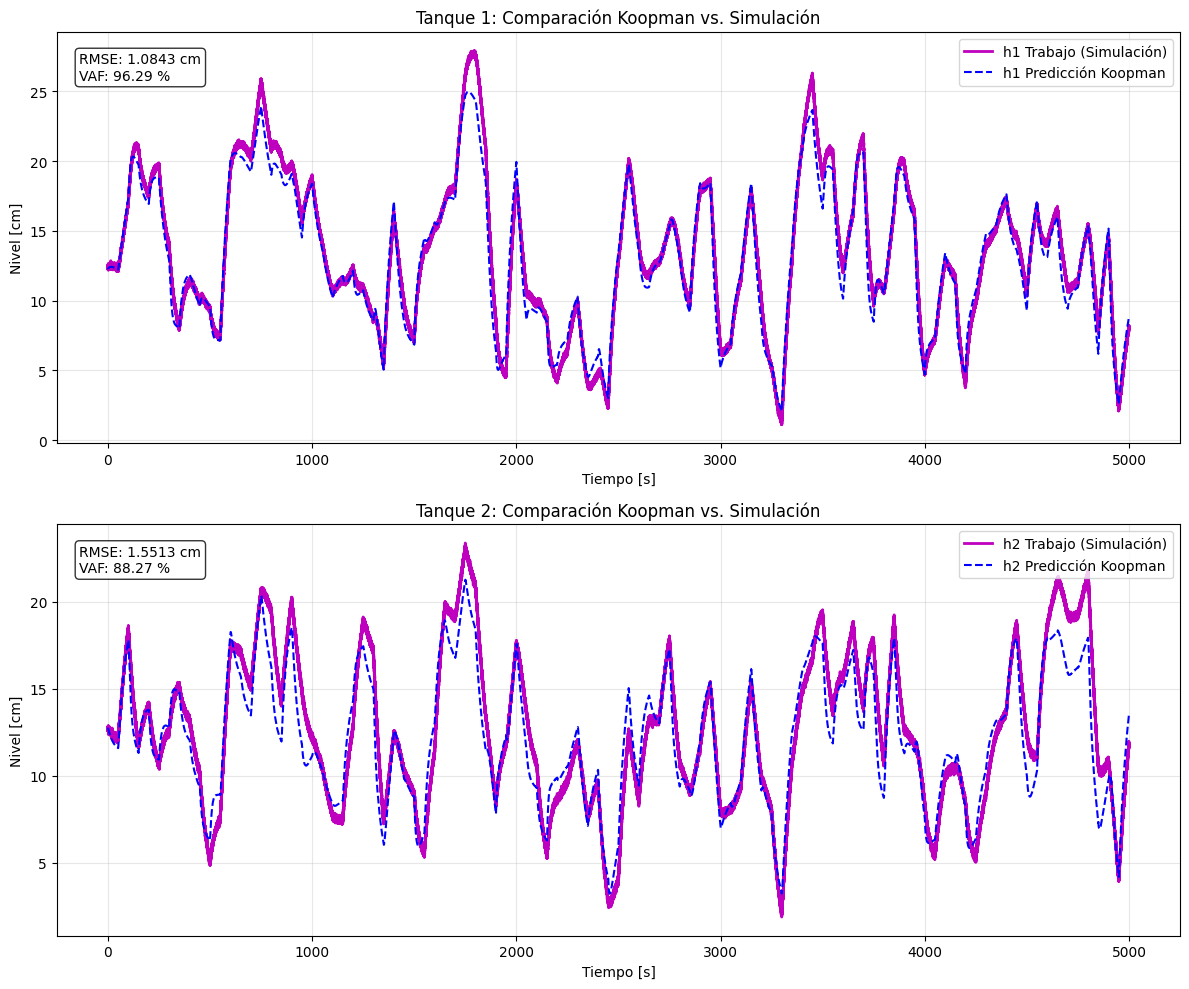

Métricas Finales Koopman:
Tanque 1 -> RMSE: 1.0843, VAF: 96.29%
Tanque 2 -> RMSE: 1.5513, VAF: 88.27%


In [15]:
# --- VISUALIZACIÓN UNIFICADA: TANQUES INFERIORES (Estilo PINN) ---
plt.figure(figsize=(12, 10))

for i in range(2): # Procesar h1 y h2
    plt.subplot(2, 1, i+1)

    # Extraer datos y métricas para claridad
    real_data = X_real_win_denorm[i, :]
    pred_data = X_koopman_win_denorm[i, :]
    metrics = reporte_metricas[f'Tanque {i+1}']

    # Plot con colores magenta 'm' y azul 'b--' para consistencia
    plt.plot(t_win, real_data, 'm', linewidth=2, label=f'h{i+1} Trabajo (Simulación)')
    plt.plot(t_win, pred_data, 'b--', linewidth=1.5, label=f'h{i+1} Predicción Koopman')

    # Etiquetas y Título estilo PINN
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Nivel [cm]')
    plt.title(f'Tanque {i+1}: Comparación Koopman vs. Simulación')

    # Añadir métricas en el cuadro de texto (bbox)
    textstr = '\n'.join((
        f"RMSE: {metrics['RMSE']:.4f} cm",
        f"VAF: {metrics['VAF']:.2f} %"
    ))

    plt.gca().text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print de consola para validación rápida
print(f"Métricas Finales Koopman:")
for i in range(2):
    m = reporte_metricas[f'Tanque {i+1}']
    print(f"Tanque {i+1} -> RMSE: {m['RMSE']:.4f}, VAF: {m['VAF']:.2f}%")

In [16]:
import pandas as pd

# 1. Crear un diccionario con los datos de tiempo y señales
# Usamos las variables que ya tienes denormalizadas
data_to_save = {
    'Tiempo [s]': t_win,
    'h1_Real [cm]': X_real_win_denorm[0, :],
    'h1_Koopman [cm]': X_koopman_win_denorm[0, :],
    'h2_Real [cm]': X_real_win_denorm[1, :],
    'h2_Koopman [cm]': X_koopman_win_denorm[1, :]
}

# 2. Crear el DataFrame
df_resultados = pd.DataFrame(data_to_save)

# 3. Guardar a CSV
# index=False evita que se guarde una columna extra con los números de fila
df_resultados.to_csv('comparacion_koopman_tanques.csv', index=False)

print("✅ Archivo 'comparacion_koopman_tanques.csv' guardado con éxito.")

# Opcional: Mostrar las primeras filas para validar
print(df_resultados.head())

✅ Archivo 'comparacion_koopman_tanques.csv' guardado con éxito.
   Tiempo [s]  h1_Real [cm]  h1_Koopman [cm]  h2_Real [cm]  h2_Koopman [cm]
0        0.00     12.345720        12.345720     12.704146        12.704146
1        0.05     12.352197        12.325689     12.569857        12.720884
2        0.10     12.537900        12.315253     12.732427        12.729473
3        0.15     12.498946        12.310171     12.748294        12.733877
4        0.20     12.486878        12.308595     12.568081        12.734756


## Visualización de tanques 3 y 4: Operador de Koopman vs Simulación

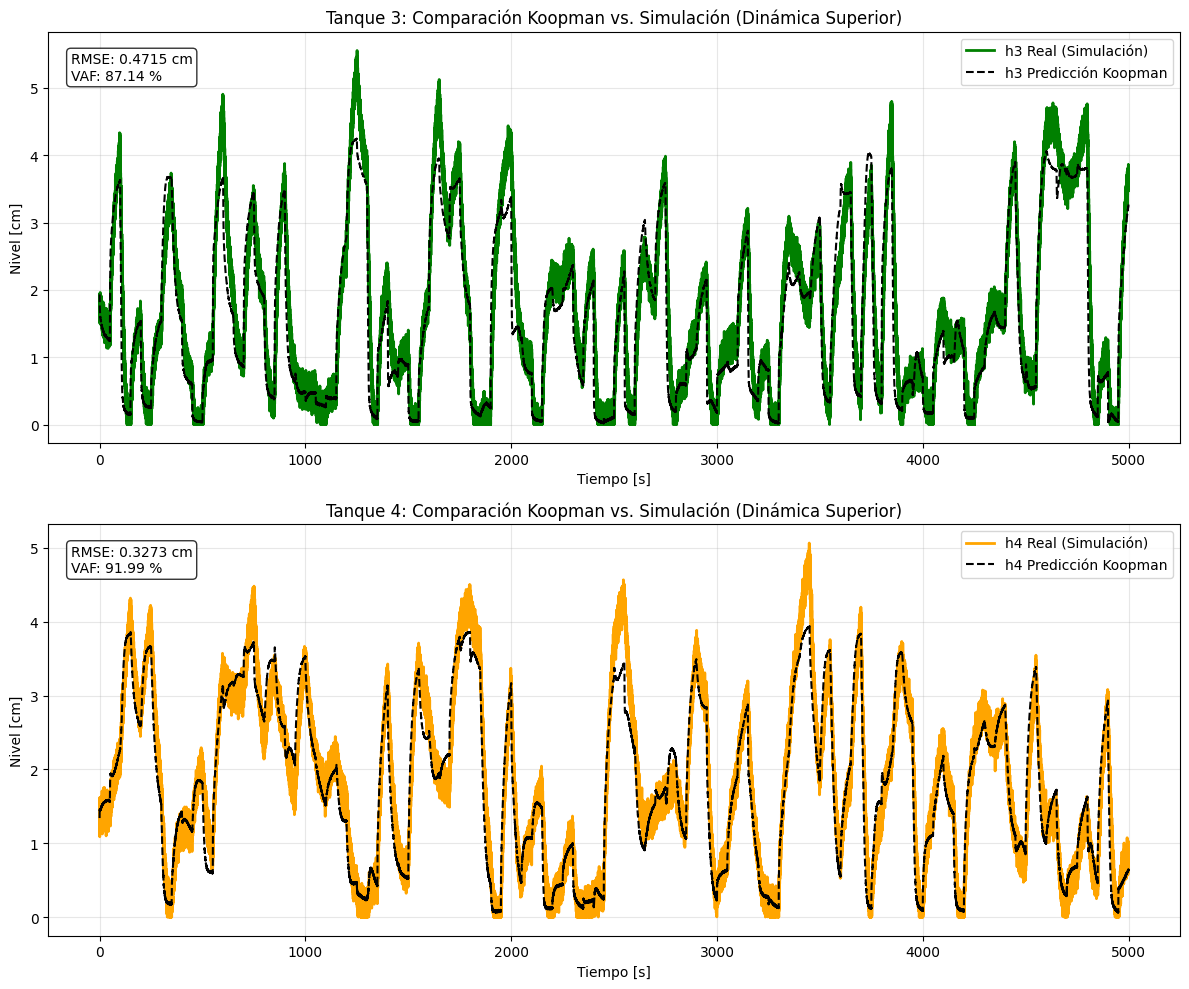


--- Métricas Finales Superiores (Koopman) ---
Tanque 3 -> RMSE: 0.4715 cm, VAF: 87.14%
Tanque 4 -> RMSE: 0.3273 cm, VAF: 91.99%


In [17]:
# --- VISUALIZACIÓN REFINADA: TANQUES SUPERIORES (h3, h4) ---
plt.figure(figsize=(12, 10), facecolor='white')

# 1. Análisis Dinámico Tanque 3
plt.subplot(2, 1, 1)
metrics3 = reporte_metricas['Tanque 3']
plt.plot(t_win, X_real_win_denorm[2, :], 'g', linewidth=2, label='h3 Real (Simulación)')
plt.plot(t_win, X_koopman_win_denorm[2, :], 'k--', linewidth=1.5, label='h3 Predicción Koopman')

plt.title('Tanque 3: Comparación Koopman vs. Simulación (Dinámica Superior)', fontsize=12)
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel [cm]')

# Inserción de cuadro de métricas h3 (Estilo PINN)
textstr3 = '\n'.join((f'RMSE: {metrics3["RMSE"]:.4f} cm', f'VAF: {metrics3["VAF"]:.2f} %'))
plt.gca().text(0.02, 0.95, textstr3, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 2. Análisis Dinámico Tanque 4
plt.subplot(2, 1, 2)
metrics4 = reporte_metricas['Tanque 4']
plt.plot(t_win, X_real_win_denorm[3, :], 'orange', linewidth=2, label='h4 Real (Simulación)')
plt.plot(t_win, X_koopman_win_denorm[3, :], 'k--', linewidth=1.5, label='h4 Predicción Koopman')

plt.title('Tanque 4: Comparación Koopman vs. Simulación (Dinámica Superior)', fontsize=12)
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel [cm]')

# Inserción de cuadro de métricas h4 (Estilo PINN)
textstr4 = '\n'.join((f'RMSE: {metrics4["RMSE"]:.4f} cm', f'VAF: {metrics4["VAF"]:.2f} %'))
plt.gca().text(0.02, 0.95, textstr4, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen en consola
print(f"\n--- Métricas Finales Superiores (Koopman) ---")
print(f"Tanque 3 -> RMSE: {metrics3['RMSE']:.4f} cm, VAF: {metrics3['VAF']:.2f}%")
print(f"Tanque 4 -> RMSE: {metrics4['RMSE']:.4f} cm, VAF: {metrics4['VAF']:.2f}%")

In [18]:
import pandas as pd

# 1. Organización de los datos en un diccionario
# Utilizamos los índices 2 y 3 que corresponden a los tanques superiores
data_superiores = {
    'Tiempo [s]': t_win,
    'h3_Real [cm]': X_real_win_denorm[2, :],
    'h3_Koopman [cm]': X_koopman_win_denorm[2, :],
    'h4_Real [cm]': X_real_win_denorm[3, :],
    'h4_Koopman [cm]': X_koopman_win_denorm[3, :]
}

# 2. Creación del DataFrame
df_superiores = pd.DataFrame(data_superiores)

# 3. Guardado en archivo .csv
nombre_archivo = 'comparacion_koopman_superiores.csv'
df_superiores.to_csv(nombre_archivo, index=False)

print(f"✅ Datos de tanques superiores exportados correctamente a: {nombre_archivo}")

# --- Exportación Opcional: Métricas de desempeño ---
metricas_superiores = pd.DataFrame([
    {'Tanque': 'h3', 'RMSE': metrics3['RMSE'], 'VAF': metrics3['VAF']},
    {'Tanque': 'h4', 'RMSE': metrics4['RMSE'], 'VAF': metrics4['VAF']}
])
metricas_superiores.to_csv('metricas_koopman_superiores.csv', index=False)
print("📊 Métricas de tanques superiores guardadas en 'metricas_koopman_superiores.csv'")

✅ Datos de tanques superiores exportados correctamente a: comparacion_koopman_superiores.csv
📊 Métricas de tanques superiores guardadas en 'metricas_koopman_superiores.csv'


## Gráficas de error de los 4 tanques

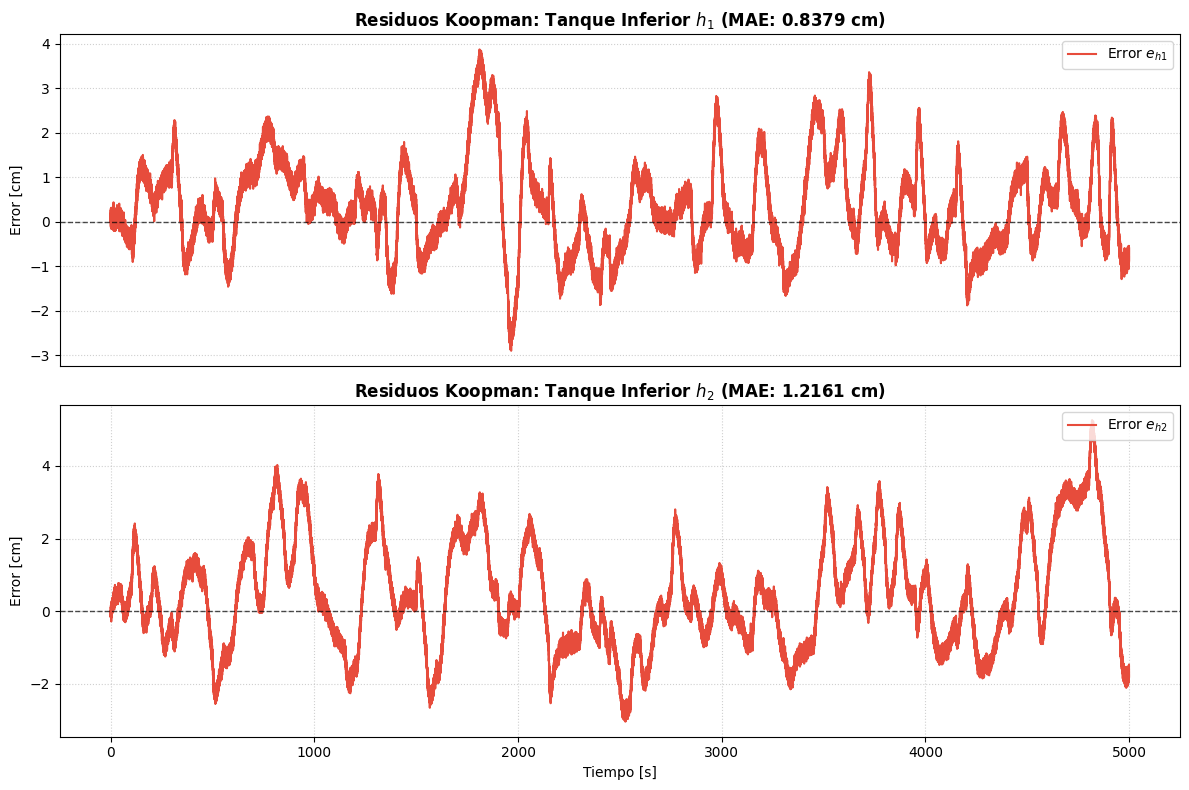

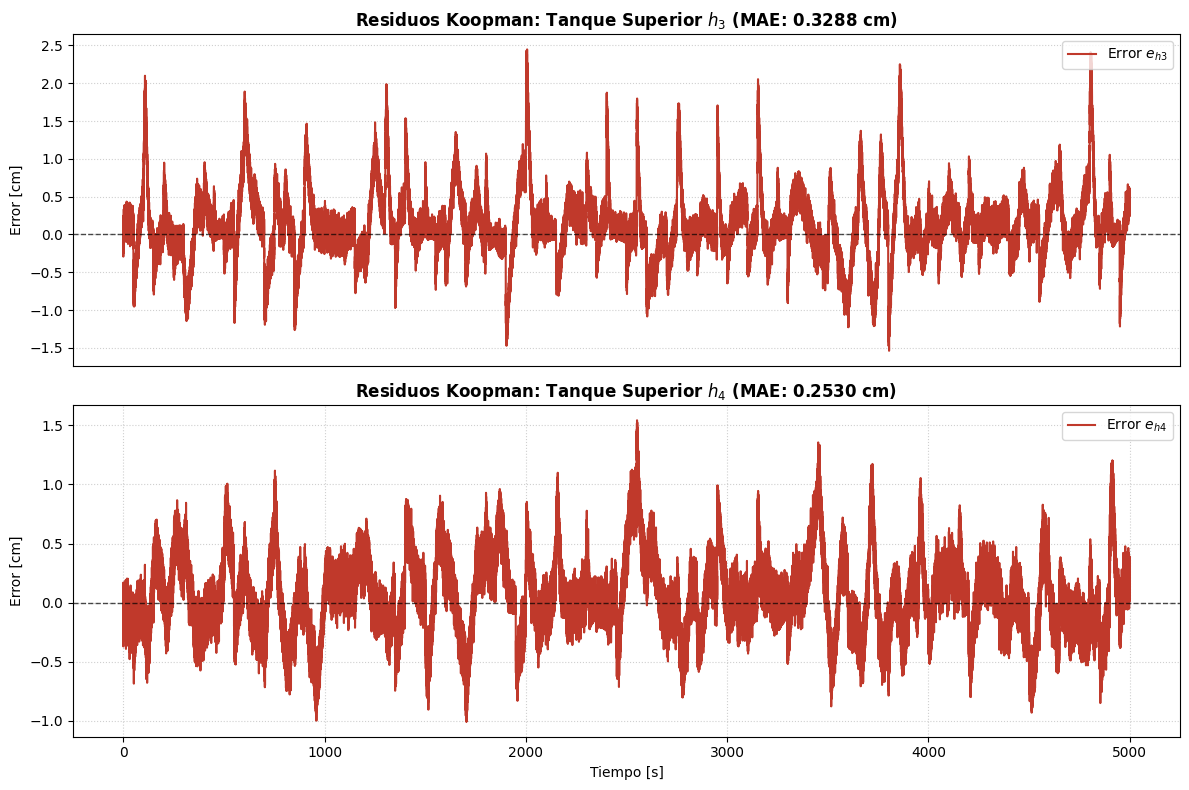

In [19]:
# --- CÁLCULO DE RESIDUOS (Koopman vs Realidad) ---
# Extraemos los errores directamente del reporte de métricas generado en la pieza anterior
errors = [reporte_metricas[f'Tanque {i+1}']['Error'] for i in range(4)]

# --- VISUALIZACIÓN: ERRORES EN TANQUES INFERIORES (h1, h2) ---
plt.figure(figsize=(12, 8), facecolor='white')

for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.plot(t_win, errors[i], color='#e74c3c', linewidth=1.5, label=f'Error $e_{{h{i+1}}}$')
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

    # Cálculo de métricas locales para el título
    mae_local = np.mean(np.abs(errors[i]))

    plt.title(f'Residuos Koopman: Tanque Inferior $h_{i+1}$ (MAE: {mae_local:.4f} cm)', fontsize=12, fontweight='bold')
    plt.ylabel('Error [cm]')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    if i == 0: plt.xticks([])

plt.xlabel('Tiempo [s]')
plt.tight_layout()
plt.show()

# --- VISUALIZACIÓN: ERRORES EN TANQUES SUPERIORES (h3, h4) ---
plt.figure(figsize=(12, 8), facecolor='white')

for i in range(2, 4):
    plt.subplot(2, 1, i-1)
    plt.plot(t_win, errors[i], color='#c0392b', linewidth=1.5, label=f'Error $e_{{h{i+1}}}$')
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

    # Cálculo de métricas locales
    mae_local = np.mean(np.abs(errors[i]))

    plt.title(f'Residuos Koopman: Tanque Superior $h_{i+1}$ (MAE: {mae_local:.4f} cm)', fontsize=12, fontweight='bold')
    plt.ylabel('Error [cm]')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    if i == 2: plt.xticks([])

plt.xlabel('Tiempo [s]')
plt.tight_layout()
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-742022944.py:12: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Distribución Global del Error de Predicción: Operador Koopman ($K_{\delta}$)', fontsize=13, fontweight='bold')
/tmp/ipython-input-742022944.py:29: SyntaxWarning: invalid escape sequence '\s'
  print(f"Desviación Estándar ($\sigma$) : {std_error:.6f} cm")
/tmp/ipython-input-742022944.py:30: SyntaxWarning: invalid escape sequence '\s'
  print(f"Confianza (Rango ±2$\sigma$)   : [{mean_error - 2*std_error:.4f}, {mean_error + 2*std_error:.4f}] cm")


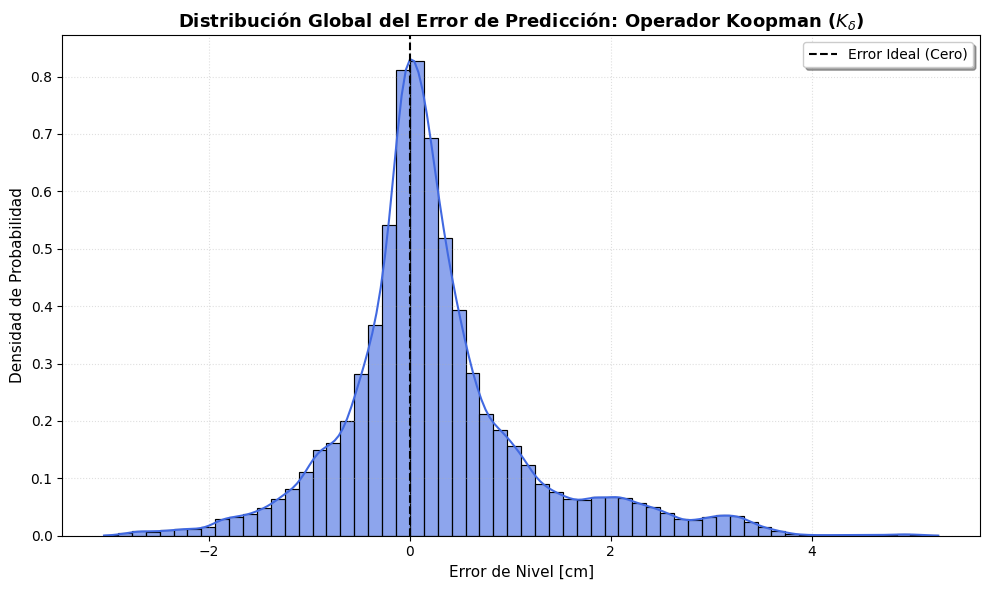


──────────────────────────────────────────────────
📊 DIAGNÓSTICO ESTADÍSTICO DE KOOPMAN
──────────────────────────────────────────────────
Media del Error (Bias)      : +0.247713 cm
Desviación Estándar ($\sigma$) : 0.957350 cm
Confianza (Rango ±2$\sigma$)   : [-1.6670, 2.1624] cm
──────────────────────────────────────────────────


In [20]:
# Configuración estética para el análisis de errores
plt.figure(figsize=(10, 6), facecolor='white')

# 1. Visualización de la distribución global (utilizando el error_full calculado en la Pieza 29)
# El color 'royalblue' diferencia este análisis del modelo PINN (rojo)
sns.histplot(error_full, kde=True, color='royalblue', bins=60, stat="density", alpha=0.6)

# 2. Inserción de línea de referencia en Error Cero para evaluar el sesgo
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Error Ideal (Cero)')

# 3. Formateo de etiquetas y títulos
plt.title('Distribución Global del Error de Predicción: Operador Koopman ($K_{\delta}$)', fontsize=13, fontweight='bold')
plt.xlabel('Error de Nivel [cm]', fontsize=11)
plt.ylabel('Densidad de Probabilidad', fontsize=11)
plt.legend(frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

# --- CÁLCULO DE MOMENTOS ESTADÍSTICOS ---
std_error = np.std(error_full)
mean_error = np.mean(error_full)

print("\n" + "─"*50)
print(f"📊 DIAGNÓSTICO ESTADÍSTICO DE KOOPMAN")
print(f"─"*50)
print(f"Media del Error (Bias)      : {mean_error:+.6f} cm")
print(f"Desviación Estándar ($\sigma$) : {std_error:.6f} cm")
print(f"Confianza (Rango ±2$\sigma$)   : [{mean_error - 2*std_error:.4f}, {mean_error + 2*std_error:.4f}] cm")
print(f"─"*50)

## Interpretación y Análisis del operador Koopman

El análisis se divide en dos perspectivas:

1. **Importancia Global de los Observables:** Se calcula la norma $L_1$ de las columnas de $K_{\delta}$ para determinar la relevancia de cada función de levantamiento en la dinámica total:
   $$I_j = \sum_{i=1}^{n_x} |K_{i,j}|$$
   Esto permite identificar si términos como los de Bernoulli ($\sqrt{h}$) o las interacciones de control ($v \cdot \sqrt{h}$) son efectivamente los que más aportan a la predicción del cambio de nivel.

2. **Mapa de Calor de Influencia (Heatmap):** Visualiza los coeficientes individuales de la matriz $K_{\delta} \in \mathbb{R}^{4 \times 18}$. Cada celda $(i, j)$ representa la sensibilidad del incremento del estado $i$ respecto al observable $j$:
   $$\Delta h_i \approx \sum_{j=1}^{18} K_{i,j} \Psi_j(x, u)$$


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1748854113.py:5: SyntaxWarning: invalid escape sequence '\s'
  '$\sqrt{h_1}$', 

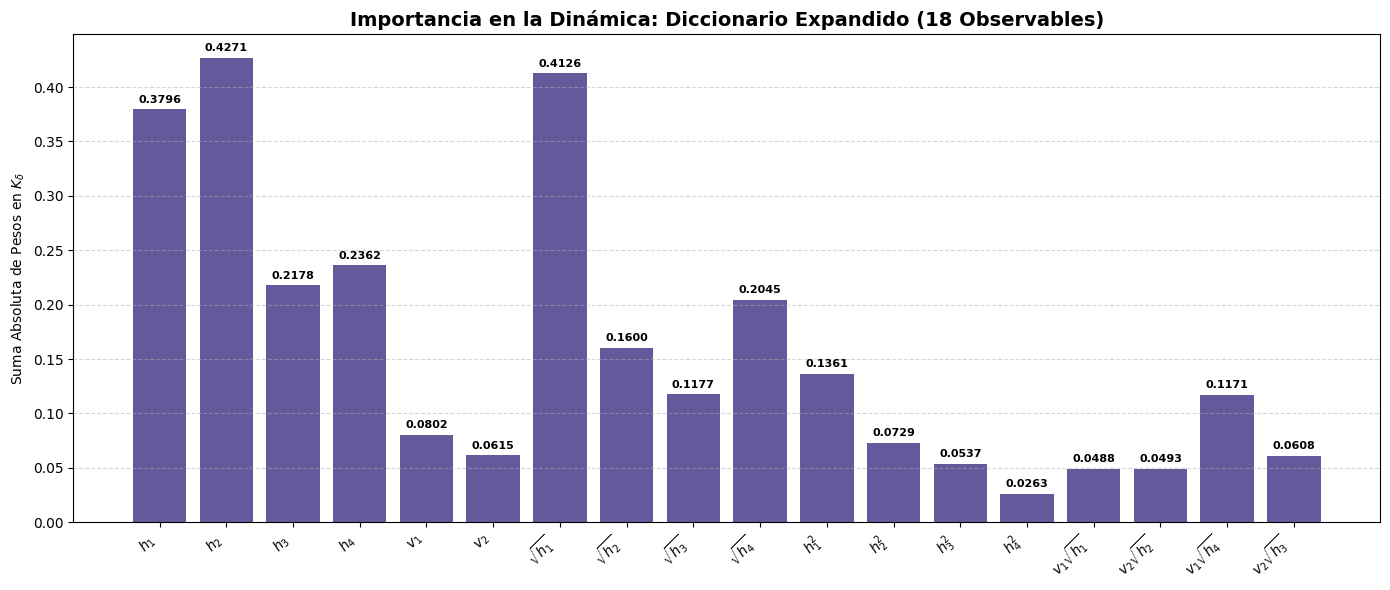

In [21]:
# 1. Definición de etiquetas para los 18 términos del espacio expandido (Lifting Space)
nombres_obs = [
    '$h_1$', '$h_2$', '$h_3$', '$h_4$',
    '$v_1$', '$v_2$',
    '$\sqrt{h_1}$', '$\sqrt{h_2}$', '$\sqrt{h_3}$', '$\sqrt{h_4}$',
    '$h_1^2$', '$h_2^2$', '$h_3^2$', '$h_4^2$',
    '$v_1\sqrt{h_1}$', '$v_2\sqrt{h_2}$',
    '$v_1\sqrt{h_4}$', '$v_2\sqrt{h_3}$'
]

# 2. Cálculo de relevancia mediante la suma de pesos absolutos (L1-norm de columnas)
importancia = np.sum(np.abs(K_delta), axis=0)

# 3. Visualización de la importancia relativa
plt.figure(figsize=(14, 6), facecolor='white')
bars = plt.bar(nombres_obs, importancia, color='darkslateblue', alpha=0.85)

plt.title('Importancia en la Dinámica: Diccionario Expandido (18 Observables)', fontsize=14, fontweight='bold')
plt.ylabel('Suma Absoluta de Pesos en $K_{\delta}$')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Inserción de etiquetas numéricas para auditoría rápida
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(importancia)*0.01),
             f'{yval:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1388888072.py:2: SyntaxWarning: invalid escape sequence '\D'
  yticklabels_delta = ['$\Delta h_1$', '$\Delta h_2$', '$\Delta h_3$', '$\Delta h_4$']
/tmp/ipython-input-1388888072.py:2: SyntaxWarning: invalid escape sequence '\D'
  yticklabels_delta = ['$\Delta h_1$', '$\Delta h_2$', '$\Delta h_3$', '$\Delta h_4$']
/tmp/ipython-input-1388888072.py:2: SyntaxWarning: invalid escape sequence '\D'
  yticklabels_delta = ['$\Delta h_1$', '$\Delta h_2$', '$\Delta h_3$', '$\Delta h_4$

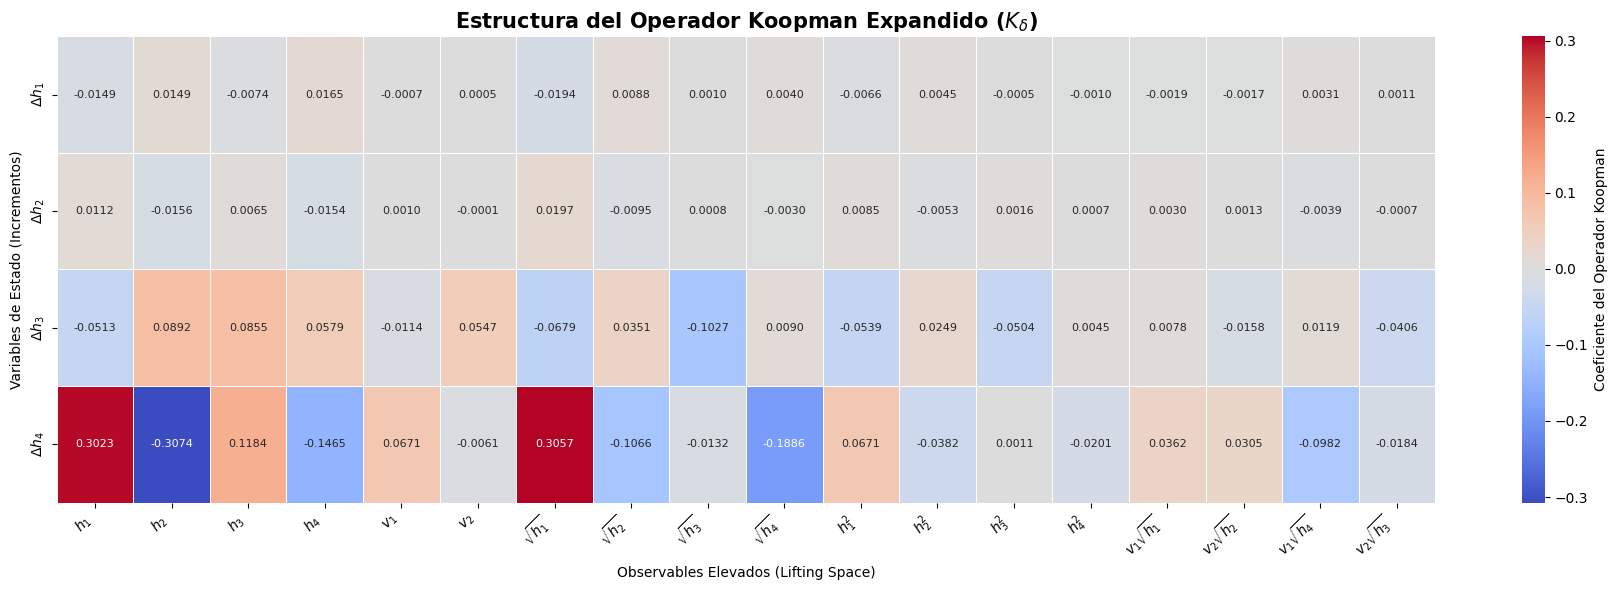

In [22]:
# 1. Definición de etiquetas para las variables de salida (Incrementos)
yticklabels_delta = ['$\Delta h_1$', '$\Delta h_2$', '$\Delta h_3$', '$\Delta h_4$']

# 2. Generación del mapa de calor (Heatmap)
plt.figure(figsize=(18, 6), facecolor='white')

# Representación matricial con paleta divergente (resalta pesos positivos vs negativos)
sns.heatmap(K_delta, annot=True, fmt=".4f", cmap='coolwarm', center=0,
            xticklabels=nombres_obs, yticklabels=yticklabels_delta,
            cbar_kws={'label': 'Coeficiente del Operador Koopman'},
            linewidths=0.5, annot_kws={"size": 8})

plt.title('Estructura del Operador Koopman Expandido ($K_{\delta}$)', fontsize=15, fontweight='bold')
plt.xlabel('Observables Elevados (Lifting Space)')
plt.ylabel('Variables de Estado (Incrementos)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Predicción de horizonte de valores futuros de las alturas de los tanques

In [23]:
def predict_horizon_edmd(K_delta, current_h, v_batches, SCALING_PARAMS):
    # Obtención de dimensiones para procesamiento por lotes (batches)
    n_samples, n_steps, _ = v_batches.shape

    # Preparación de vectores de normalización para estados (niveles)
    h_min = np.array([SCALING_PARAMS[f'h{i}']['min'] for i in range(1, 5)]).reshape(1, 4)
    h_max = np.array([SCALING_PARAMS[f'h{i}']['max'] for i in range(1, 5)]).reshape(1, 4)
    h_range = h_max - h_min + 1e-8

    # Preparación de vectores de normalización para entradas (voltajes)
    v_min = np.array([SCALING_PARAMS['v1']['min'], SCALING_PARAMS['v2']['min']]).reshape(1, 2)
    v_max = np.array([SCALING_PARAMS['v1']['max'], SCALING_PARAMS['v2']['max']]).reshape(1, 2)
    v_range = v_max - v_min + 1e-8

    # Inicialización de trayectorias y estado actual para todos los escenarios
    h_current = np.tile(current_h, (n_samples, 1))
    all_preds = np.zeros((4, n_samples, n_steps))

    # Bucle de simulación sobre el horizonte de tiempo
    for k in range(n_steps):
        # Normalización y clipping preventivo para estabilidad numérica
        h_norm = np.clip((h_current - h_min) / h_range, 0.0, 1.0)
        v_norm = (v_batches[:, k, :] - v_min) / v_range

        # Construcción del vector de observables expandido (Lifting de 18 términos)
        v1_n, v2_n = v_norm[:, 0:1], v_norm[:, 1:2]
        sqrt_h_n = np.sqrt(np.maximum(h_norm, 1e-6))
        h_sq_n = h_norm**2

        psi_k = np.concatenate([
            h_norm, v1_n, v2_n, sqrt_h_n, h_sq_n,
            v1_n * sqrt_h_n[:, 0:1], v2_n * sqrt_h_n[:, 1:2],
            v1_n * sqrt_h_n[:, 3:4], v2_n * sqrt_h_n[:, 2:3]
        ], axis=1)

        # Cálculo del incremento normalizado mediante el operador K_delta
        delta_x_norm = psi_k @ K_delta.T

        # Actualización de estado físico y des-normalización del incremento
        h_next = h_current + (delta_x_norm * h_range)

        # Saturación final basada en límites físicos de los tanques
        h_next = np.clip(h_next, h_min, h_max)

        # Almacenamiento de la predicción y actualización del estado de iteración
        all_preds[:, :, k] = h_next.T
        h_current = h_next

    # Retorno de predicciones segmentadas por tanque
    return tuple(all_preds[i] for i in range(4))

## Función de costo del controlador MPC

In [24]:
def mpc_cost_function(v_batches, h_preds, h_refs_horizon, v_prev, params):
    # Inicialización de dimensiones y vector de costo total
    n_samples, n_steps, _ = v_batches.shape
    total_cost = np.zeros(n_samples)

    # Extracción de parámetros físicos para el cálculo de equilibrio
    g, a, k, gamma = params['g'], [params[f'a{i}'] for i in range(1, 5)], [params['k1'], params['k2']], [params['gamma1'], params['gamma2']]
    det = gamma[0] + gamma[1] - 1
    sqrt_2g = np.sqrt(2 * g)
    h_target = h_refs_horizon[:, -1]

    # Cálculo analítico del voltaje de estado estacionario (Steady State)
    v1_ss = (gamma[1]*a[0]*sqrt_2g*np.sqrt(h_target[0]) - (1-gamma[1])*a[1]*sqrt_2g*np.sqrt(h_target[1])) / (k[0]*det)
    v2_ss = (gamma[0]*a[1]*sqrt_2g*np.sqrt(h_target[1]) - (1-gamma[0])*a[0]*sqrt_2g*np.sqrt(h_target[0])) / (k[1]*det)
    v_ss = np.array([np.clip(v1_ss, 0, 15), np.clip(v2_ss, 0, 15)])

    # Cálculo de los niveles correspondientes para los tanques superiores en equilibrio
    h3_ss = ((1 - gamma[1]) * k[1] * v_ss[1] / a[2])**2 / (2 * g)
    h4_ss = ((1 - gamma[0]) * k[0] * v_ss[0] / a[3])**2 / (2 * g)
    h_ss_full = np.array([h_target[0], h_target[1], h3_ss, h4_ss])

    # Penalización por error de seguimiento de trayectoria en los 4 tanques
    Q_h = np.array([5e6, 5e6, 5e4, 5e4])
    for i in range(4):
        ref_path = h_refs_horizon[i][np.newaxis, :]
        total_cost += np.mean(Q_h[i] * (h_preds[i] - ref_path)**2, axis=1)

    # Penalización del error en el estado final del horizonte (Costo Terminal)
    Q_terminal = 5e4
    for i in range(4):
        total_cost += Q_terminal * (h_preds[i][:, -1] - h_ss_full[i])**2

    # Penalización por desviación del voltaje respecto al equilibrio ideal
    R_ss = 6e4
    total_cost += np.sum(R_ss * (v_batches - v_ss.reshape(1, 1, 2))**2, axis=(1, 2))

    # Penalización del incremento de voltaje para suavizar la acción de control
    S_smooth = 5e5
    v_prev_expanded = v_prev.reshape(1, 1, 2)
    v_full_path = np.concatenate([np.repeat(v_prev_expanded, n_samples, axis=0), v_batches], axis=1)
    dv = np.diff(v_full_path, axis=1)
    total_cost += np.sum(S_smooth * (dv**2), axis=(1, 2))

    return total_cost

## Inversión analítica del modelo (Estado estacionario)

Matemáticamente, se busca el estado donde $\frac{dh_i}{dt} = 0$. Resolviendo el sistema algebraico, obtenemos los voltajes de estado estacionario ($v_{ss}$):

$$v_1 = \frac{\gamma_2 a_1 \sqrt{2gh_1} - (1 - \gamma_2) a_2 \sqrt{2gh_2}}{k_1 (\gamma_1 + \gamma_2 - 1)}$$
$$v_2 = \frac{\gamma_1 a_2 \sqrt{2gh_2} - (1 - \gamma_1) a_1 \sqrt{2gh_1}}{k_2 (\gamma_1 + \gamma_2 - 1)}$$

Una vez obtenidos los voltajes, los niveles de equilibrio de los tanques superiores se derivan directamente de la igualdad entre el flujo de entrada de la bomba y el flujo de salida por gravedad:

$$h_3 = \frac{1}{2g} \left( \frac{(1 - \gamma_2) k_2 v_2}{a_3} \right)^2, \quad h_4 = \frac{1}{2g} \left( \frac{(1 - \gamma_1) k_1 v_1}{a_4} \right)^2$$

Esta pieza es fundamental para el control feedforward y para establecer referencias factibles en el espacio de estados, evitando que el controlador intente alcanzar puntos de operación físicamente inconsistentes.

In [25]:
def compute_steady_state(h1, h2, params):
    # Extracción de parámetros físicos y geométricos
    g = params['g']
    a1, a2, a3, a4 = params['a1'], params['a2'], params['a3'], params['a4']
    k1, k2 = params['k1'], params['k2']
    gamma1, gamma2 = params['gamma1'], params['gamma2']

    # Pre-cálculo de raíces cuadradas para optimizar desempeño
    sqrt_2g = math.sqrt(2 * g)
    sqrt_h1 = math.sqrt(max(h1, 1e-6))
    sqrt_h2 = math.sqrt(max(h2, 1e-6))

    # Cálculo analítico del voltaje v1 necesario para el equilibrio
    numerador_v1 = gamma2 * a1 * sqrt_2g * sqrt_h1 - (1 - gamma2) * a2 * sqrt_2g * sqrt_h2
    denominador_v1 = k1 * (gamma1 + gamma2 - 1)
    v1 = numerador_v1 / denominador_v1

    # Cálculo analítico del voltaje v2 necesario para el equilibrio
    numerador_v2 = gamma1 * a2 * sqrt_2g * sqrt_h2 - (1 - gamma1) * a1 * sqrt_2g * sqrt_h1
    denominador_v2 = k2 * (gamma1 + gamma2 - 1)
    v2 = numerador_v2 / denominador_v2

    # Determinación del nivel h3 resultante (protección contra voltajes negativos)
    if v2 >= 0:
        h3 = (( (1 - gamma2) * k2 * v2 / a3 )**2) / (2 * g)
    else:
        h3 = 0.0

    # Determinación del nivel h4 resultante (protección contra voltajes negativos)
    if v1 >= 0:
        h4 = (( (1 - gamma1) * k1 * v1 / a4 )**2) / (2 * g)
    else:
        h4 = 0.0

    return v1, v2, h3, h4

## Paso de control del controlador MPC

Esta función implementa el ciclo de decisión del **Control Predictivo basado en el Modelo (MPC)**, sustituyendo los modelos diferenciales tradicionales (o redes neuronales tipo PINN) por el operador **Koopman $K_{\delta}$**. El algoritmo utiliza una técnica de optimización estocástica (muestreo de candidatos) para encontrar la acción de control óptima en tiempo real.

In [26]:
def mpc_control_step_koopman(K_delta, current_h, t_actual, reference_func, v_prev, N_p, dt,
                             SCALING_PARAMS, params, N_c, v_last_best=None, n_samples=2500,
                             std_sensor=0.10, std_actuator=0.15):

    v_max_phys = SCALING_PARAMS['v1']['max']

    # --- RUIDO DE MEDICIÓN (SENSOR) ---
    # El MPC recibe una lectura imperfecta del estado actual de los tanques
    h_noisy = current_h + np.random.normal(0, std_sensor, size=4)
    h_noisy = np.maximum(h_noisy, 0) # Protección física: niveles no negativos

    # 1. Generación de referencias futuras para el horizonte de predicción
    h_refs_horizon = np.zeros((4, N_p))
    for i in range(N_p):
        t_futuro = t_actual + i * dt
        h1_r, h2_r, _, _ = reference_func(t_futuro)
        _, _, h3_ss, h4_ss = compute_steady_state(h1_r, h2_r, params)
        h_refs_horizon[:, i] = [h1_r, h2_r, h3_ss, h4_ss]

    # 2. Cálculo del voltaje de equilibrio ("Faro")
    v1_faro, v2_faro, _, _ = compute_steady_state(h_refs_horizon[0, -1], h_refs_horizon[1, -1], params)
    v_faro = np.clip(np.array([v1_faro, v2_faro]), 0.0, v_max_phys)

    # 3. Inicialización de la población de candidatos
    v_candidates = np.empty((n_samples, N_c, 2), dtype=np.float32)
    v_candidates[0] = np.tile(v_faro, (N_c, 1))

    if v_last_best is not None:
        v_init = np.full((N_c, 2), v_prev)
        n_copy = min(v_last_best.shape[0] - 1, N_c - 1)
        v_init[:n_copy] = v_last_best[1:n_copy+1]
        v_init[n_copy:] = v_last_best[-1]
        v_candidates[1] = v_init
    else:
        v_candidates[1] = v_candidates[0]

    # 4. Mutación estocástica adaptativa (Usamos la lectura ruidosa para calcular el error)
    error_h = np.linalg.norm(h_noisy[:2] - h_refs_horizon[:2, 0])
    std_mut = 0.8 if error_h > 1.5 else 0.1
    n_exp = (n_samples - 2) // 2

    v_candidates[2:2+n_exp] = np.clip(
        v_candidates[0] + np.random.normal(0, std_mut, (n_exp, N_c, 2)), 0.0, v_max_phys
    )
    v_candidates[2+n_exp:] = np.clip(
        v_candidates[1] + np.random.normal(0, std_mut * 0.5, (n_samples - (2+n_exp), N_c, 2)), 0.0, v_max_phys
    )

    # 5. Evaluación masiva usando Koopman (Basada en el estado ruidoso h_noisy)
    v_batches = np.repeat(v_candidates, N_p // N_c + 1, axis=1)[:, :N_p, :]
    h_p = predict_horizon_edmd(K_delta, h_noisy, v_batches, SCALING_PARAMS)

    # Evaluación de la función de costo
    costs = mpc_cost_function(v_batches, h_p, h_refs_horizon, v_prev, params)

    # 6. Selección de la mejor acción y aplicación de restricción de suavidad
    best_idx = np.argmin(costs)
    v_next = v_candidates[best_idx][0]

    # Slew-rate limit
    max_delta = 2.0
    v_final = np.clip(v_next, v_prev - max_delta, v_prev + max_delta)

    # --- RUIDO EN LA ACCIÓN (ACTUADOR) ---
    # Simula inestabilidad en la potencia aplicada a las bombas
    v_final_noisy = v_final + np.random.normal(0, std_actuator, size=2)
    v_final_noisy = np.clip(v_final_noisy, 0.0, v_max_phys)

    return v_final_noisy, v_candidates[best_idx]

## Catálogo de referencias para el controlador MPC

In [27]:
import numpy as np

def ref_constante(t, h1=15.0, h2=12.0):
    return np.array([h1, h2, 0.0, 0.0])


def ref_cuadrada(t, amp_high=[18.0, 10.0], amp_low=[10.0, 16.0], periodo=500.0):
    if (t % periodo) < (periodo / 2):
        return np.array([amp_high[0], amp_high[1], 0.0, 0.0])
    return np.array([amp_low[0], amp_low[1], 0.0, 0.0])


def ref_sinusoidal(t, bias=[14.0, 14.0], amp=[4.0, 4.0], periodo=600.0, fase_h1=0, fase_h2=np.pi):
    h1 = bias[0] + amp[0] * np.sin(2 * np.pi * t / periodo + fase_h1)
    h2 = bias[1] + amp[1] * np.sin(2 * np.pi * t / periodo + fase_h2)
    return np.array([h1, h2, 0.0, 0.0])


def ref_filtro_rc(t, h_min=10.0, h_max=18.0, periodo=600.0, tau=50.0):
    fase = t % periodo
    semiciclo = periodo / 2
    if fase < semiciclo:
        val = h_min + (h_max - h_min) * (1 - np.exp(-fase / tau))
    else:
        fase_descarga = fase - semiciclo
        val = h_min + (h_max - h_min) * (np.exp(-fase_descarga / tau))
    return np.array([val, val, 0.0, 0.0])


def ref_trapezoidal(t, h_min=10.0, h_max=18.0, periodo=600.0, t_rampa=100.0):
    fase = t % periodo
    semiciclo = periodo / 2
    if fase < t_rampa:
        val = h_min + (h_max - h_min) * (fase / t_rampa)
    elif fase < semiciclo:
        val = h_max
    elif fase < (semiciclo + t_rampa):
        val = h_max - (h_max - h_min) * ((fase - semiciclo) / t_rampa)
    else:
        val = h_min
    return np.array([val, val, 0.0, 0.0])

def ref_escalera_personalizada(t):
    # Definimos los niveles para h1 y h2 (puedes ajustarlos si h2 debe ser distinto)
    if t < 300:
        val1 = 12.0
        val2 = 16.0
    elif t < 600:
        val1 = 15.0
        val2 = 14.0
    elif t < 900:
        val1 = 10.0
        val2 = 10.0
    elif t < 1200:
        val1 = 14.0
        val2 = 15.0
    else:
        val1 = 16.0
        val2 = 12.0

    # Retornamos el formato [h1, h2, h3_ss, h4_ss]
    # h3 y h4 se envían en 0.0 para que el MPC calcule su equilibrio
    return np.array([val1, val2, 0.0, 0.0])

## Catálogo de referencias aplicadas como meta del controlador MPC

In [1]:
# --- SELECCIÓN DE ESCENARIO PARA EL NMPC ---

# Onda cuadrada estándar
# REFERENCIA_ACTUAL = lambda t: ref_cuadrada(t, amp_high=[18.0, 10.0], amp_low=[10.0, 18.0], periodo=1000.0)

# Oscilación suave: h1 y h2 suben y bajan juntos.
#REFERENCIA_ACTUAL = lambda t: ref_sinusoidal(t, bias=[14.0, 14.0], amp=[3.0, 3.0], periodo=1000.0, fase_h1=0, fase_h2=np.pi)

# Contrafase (Efecto Tijera): Mientras h1 sube, h2 baja. Máximo estrés MIMO.
# REFERENCIA_ACTUAL = lambda t: ref_sinusoidal(t, bias=[14.0, 14.0], amp=[3.0, -3.0], periodo=400.0, fase_h1=0, fase_h2=np.pi)
REFERENCIA_ACTUAL = lambda t: ref_escalera_personalizada(t)

# Asimétrica: h1 oscila mucho y h2 casi nada.
# REFERENCIA_ACTUAL = lambda t: ref_sinusoidal(t, bias=[15.0, 12.0], amp=[3.0, 0.7], periodo=400.0, fase_h1=0, fase_h2=np.pi)

# Filtro RC: Simula carga/descarga natural.
# REFERENCIA_ACTUAL = lambda t: ref_filtro_rc(t, h_min=10.0, h_max=12.0, periodo=200.0, tau=100.0)

# Trapezoidal: Sube en rampa. Evita picos de voltaje.
# REFERENCIA_ACTUAL = lambda t: ref_trapezoidal(t, h_min=10.0, h_max=15.0, periodo=1000.0, t_rampa=200.0)

# Cambio de consigna único: Empieza en 12cm y a los 500s sube a 18cm para siempre.
# REFERENCIA_ACTUAL = lambda t: ref_constante(t, 18, 18) if t > 500 else ref_constante(t, 12, 12)

# Referencia "Escalera": Sube 2cm cada 300 segundos
# REFERENCIA_ACTUAL = lambda t: ref_constante(t, 10 + (2 * (t // 300)), 10 + (2 * (t // 300)))

## Parámetros para funcionamiento del controlador MPC

In [28]:
# --- Configuración de la Simulación en Lazo Cerrado ---
t_sim_final = 1500  # Duración total de la prueba en segundos
dt_control = 1      # Periodo de muestreo del controlador (1 Hz)
steps = int(t_sim_final / dt_control)

# Consolidación de parámetros físicos para el modelo interno del MPC
params_mpc = {
    'A1': A1, 'A2': A2, 'A3': A3, 'A4': A4,
    'a1': a1, 'a2': a2, 'a3': a3, 'a4': a4,
    'g': g, 'k1': k1, 'k2': k2,
    'gamma1': gamma1, 'gamma2': gamma2
}

# Inicialización del estado inicial de la planta
h_actual = np.array(h0, dtype=np.float32)

# Inicialización de matrices de telemetría (Historial de datos)
history_h = np.zeros((steps, 4))   # Niveles reales de los 4 tanques
history_v = np.zeros((steps, 2))   # Voltajes aplicados por el controlador
history_ref = np.zeros((steps, 4)) # Referencias (h1, h2) y objetivos de equilibrio (h3, h4)

# Variables de control persistentes
v_aplicado = np.array([0.0, 0.0], dtype=np.float32)
v_best_seq = None  # Almacenamiento de la trayectoria óptima para Warm Start

# Mapeo de los valores de normalización del EDMD a la estructura del MPC
SCALING_PARAMS = {
    'h1': {'min': 0.0, 'max': X_max[0]},
    'h2': {'min': 0.0, 'max': X_max[1]},
    'h3': {'min': 0.0, 'max': X_max[2]},
    'h4': {'min': 0.0, 'max': X_max[3]},
    'v1': {'min': 0.0, 'max': U_max[0]},
    'v2': {'min': 0.0, 'max': U_max[1]}
}

## Bucle de control en lazo cerrado (Planta vs. MPC-Koopman)

Este es el núcleo ejecutivo del proyecto. En este bucle, se enfrenta el **Operador de Koopman** (actuando como cerebro del controlador) contra la **Planta Real** (simulada mediante las ecuaciones diferenciales de Bernoulli). Es una prueba de fuego para la identificación realizada previamente.

In [29]:
print(f"--- Iniciando Simulación MPC-Koopman (Modelo Incremental) ---")
start_wall_time = time.time()

# Estructura de diagnóstico para monitoreo de estabilidad numérica
diagnostics = {'nan_count': 0, 'solve_ivp_errors': 0}

for k in range(steps):
    t_actual = k * dt_control

    # 1. Obtención de referencia dinámica y cálculo de equilibrio guía
    h1_r, h2_r, _, _ = REFERENCIA_ACTUAL(t_actual)
    v1_ss, v2_ss, h3_ss, h4_ss = compute_steady_state(h1_r, h2_r, params_mpc)
    history_ref[k] = [h1_r, h2_r, h3_ss, h4_ss]

    # 2. Decisión del MPC usando el Operador de Koopman (Exploración de 2500 candidatos)
    v_aplicado, v_best_seq = mpc_control_step_koopman(
        K_delta=K_delta,
        current_h=h_actual,
        t_actual=t_actual,
        reference_func=REFERENCIA_ACTUAL,
        v_prev=v_aplicado,
        N_p=50,                  # Horizonte de predicción
        dt=dt_control,
        SCALING_PARAMS=SCALING_PARAMS,
        params=params_mpc,
        N_c=5,                   # Horizonte de control (pasos de cambio)
        v_last_best=v_best_seq,
        n_samples=2500           # Población de búsqueda
    )

    # 3. Definición de la dinámica real del sistema para la integración
    def planta_cuadruple_ode(t_val, h, v1, v2):
        h_s = np.maximum(h, 1e-6)
        # Ecuaciones de balance de masa (Bernoulli)
        dh1dt = -(params_mpc['a1']/params_mpc['A1'])*np.sqrt(2*params_mpc['g']*h_s[0]) + \
                (params_mpc['a3']/params_mpc['A1'])*np.sqrt(2*params_mpc['g']*h_s[2]) + \
                (params_mpc['gamma1']*params_mpc['k1']*v1)/params_mpc['A1']

        dh2dt = -(params_mpc['a2']/params_mpc['A2'])*np.sqrt(2*params_mpc['g']*h_s[1]) + \
                (params_mpc['a4']/params_mpc['A2'])*np.sqrt(2*params_mpc['g']*h_s[3]) + \
                (params_mpc['gamma2']*params_mpc['k2']*v2)/params_mpc['A2']

        dh3dt = -(params_mpc['a3']/params_mpc['A3'])*np.sqrt(2*params_mpc['g']*h_s[2]) + \
                ((1-params_mpc['gamma2'])*params_mpc['k2']*v2)/params_mpc['A3']

        dh4dt = -(params_mpc['a4']/params_mpc['A4'])*np.sqrt(2*params_mpc['g']*h_s[3]) + \
                ((1-params_mpc['gamma1'])*params_mpc['k1']*v1)/params_mpc['A4']
        return [dh1dt, dh2dt, dh3dt, dh4dt]

    # 4. Integración numérica (RK45) para avanzar un paso en el tiempo real
    try:
        sol = solve_ivp(planta_cuadruple_ode, [t_actual, t_actual + dt_control],
                        h_actual, args=(v_aplicado[0], v_aplicado[1]), method='RK45')
        h_actual = sol.y[:, -1]
    except Exception as e:
        diagnostics['solve_ivp_errors'] += 1
        print(f"\n[ERROR] solve_ivp falló en T={t_actual}s: {e}")
        if diagnostics['solve_ivp_errors'] > 3: break

    # Registro de datos en el historial
    history_h[k] = h_actual
    history_v[k] = v_aplicado

    # Monitor de consola cada 50 pasos
    if k % 50 == 0:
        print(f"T: {t_actual:>6.1f}s | "
              f"h1: {h_actual[0]:5.2f}/{h1_r:2.1f} | "
              f"h2: {h_actual[1]:5.2f}/{h2_r:2.1f} | "
              f"v: [{v_aplicado[0]:4.2f}, {v_aplicado[1]:4.2f}]")

total_time = time.time() - start_wall_time
print(f"\n--- Simulación Finalizada en {total_time:.2f}s ---")

--- Iniciando Simulación MPC-Koopman (Modelo Incremental) ---
T:    0.0s | h1: 12.31/12.0 | h2: 12.64/16.0 | v: [1.88, 2.05]
T:   50.0s | h1: 11.79/12.0 | h2: 14.44/16.0 | v: [2.69, 3.76]
T:  100.0s | h1: 12.01/12.0 | h2: 15.44/16.0 | v: [2.34, 3.59]
T:  150.0s | h1: 12.05/12.0 | h2: 15.91/16.0 | v: [2.33, 4.05]
T:  200.0s | h1: 12.03/12.0 | h2: 15.95/16.0 | v: [2.78, 3.67]
T:  250.0s | h1: 12.10/12.0 | h2: 16.11/16.0 | v: [2.90, 3.97]
T:  300.0s | h1: 14.29/15.0 | h2: 14.55/14.0 | v: [4.01, 2.86]
T:  350.0s | h1: 14.78/15.0 | h2: 14.13/14.0 | v: [3.05, 3.28]
T:  400.0s | h1: 14.82/15.0 | h2: 14.12/14.0 | v: [3.71, 3.03]
T:  450.0s | h1: 14.92/15.0 | h2: 14.05/14.0 | v: [3.63, 2.63]
T:  500.0s | h1: 14.97/15.0 | h2: 14.09/14.0 | v: [3.64, 2.92]
T:  550.0s | h1: 14.92/15.0 | h2: 14.03/14.0 | v: [3.39, 3.11]
T:  600.0s | h1: 11.07/10.0 | h2: 11.79/10.0 | v: [2.87, 2.44]
T:  650.0s | h1: 10.12/10.0 | h2: 10.57/10.0 | v: [2.63, 2.58]
T:  700.0s | h1: 10.05/10.0 | h2: 10.21/10.0 | v: [2.62,

In [30]:
rtf = total_time / t_sim_final
avg_step_ms = (total_time / steps) * 1000

print("-" * 40)
print(f"MÉTRICAS DE RENDIMIENTO:")
print(f"RTF (Real-Time Factor): {rtf:.4f}")
print(f"Tiempo promedio por paso: {avg_step_ms:.2f} ms")
print(f"Frecuencia de control: {1/(avg_step_ms/1000):.1f} Hz")

if rtf < 1.0:
    print(f"ESTADO: APTO PARA TIEMPO REAL ✅ ({1/rtf:.1f}x más rápido)")
else:
    print(f"ESTADO: SOBRECARGADO ⚠️ (Requiere {rtf:.1f}s para procesar 1s real)")
print("-" * 40)

----------------------------------------
MÉTRICAS DE RENDIMIENTO:
RTF (Real-Time Factor): 0.0519
Tiempo promedio por paso: 51.92 ms
Frecuencia de control: 19.3 Hz
ESTADO: APTO PARA TIEMPO REAL ✅ (19.3x más rápido)
----------------------------------------


## Visualización y evaluación del control en lazo cerrado

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-159218131.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Seguimiento de Trayectoria: MPC basado en Operador de Koopman ($\Delta$-EDMD)', fontsize=14, fontweight='bold')


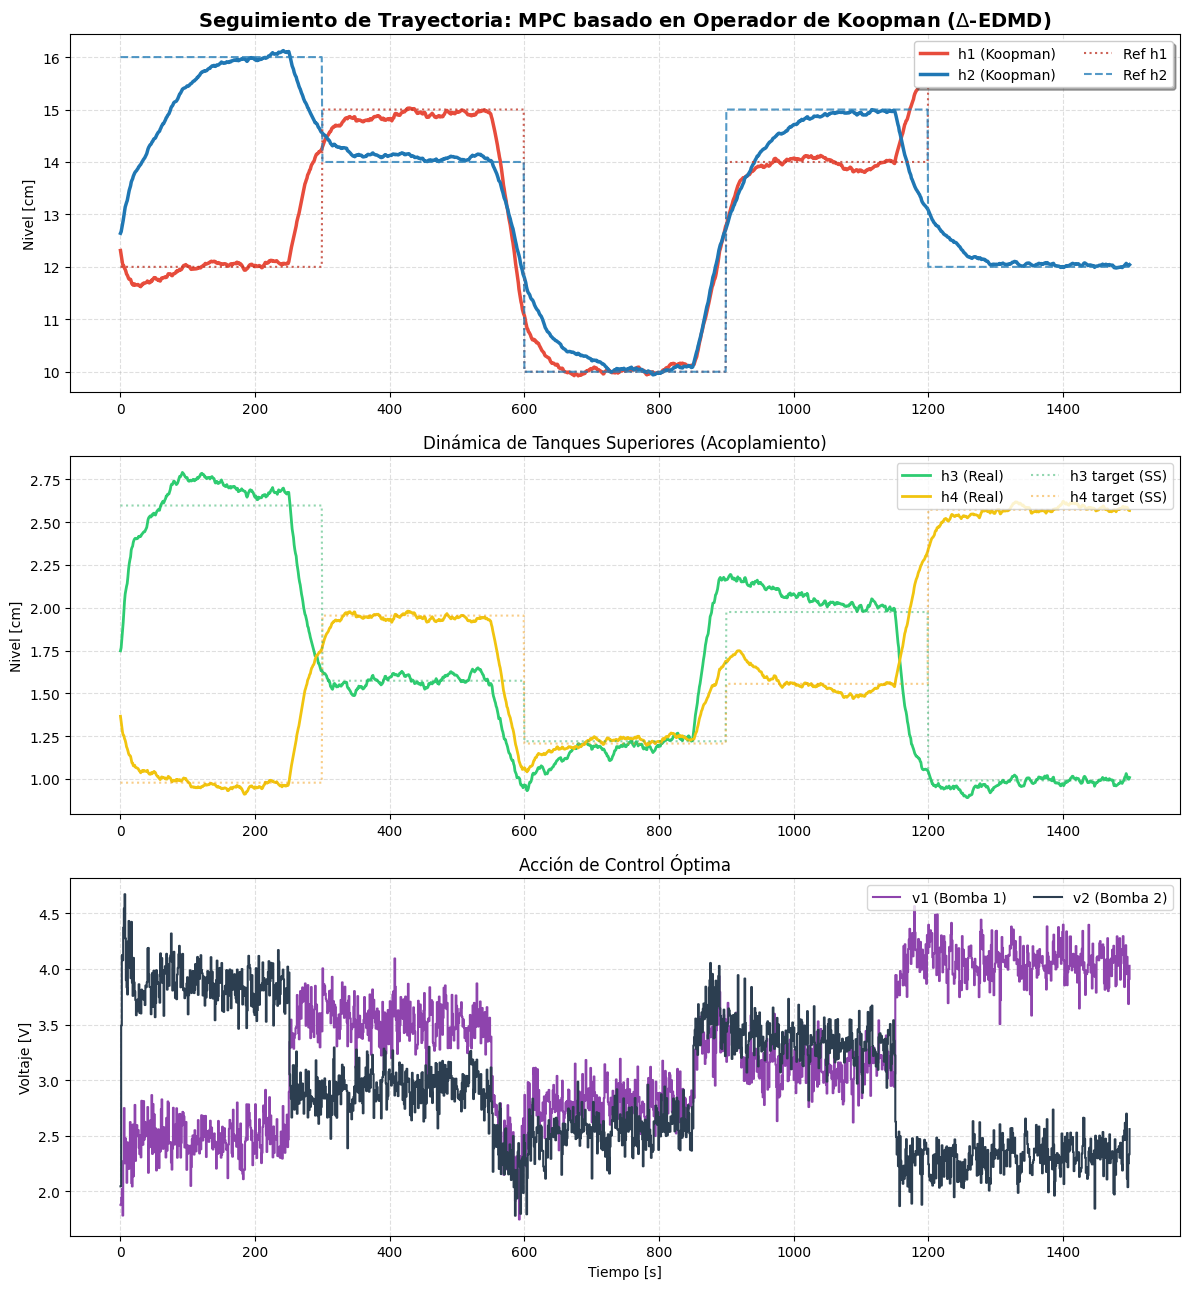

In [31]:
import matplotlib.pyplot as plt

# Re-cálculo dinámico del eje del tiempo basado en el historial recolectado
history_t = np.arange(0, len(history_h)) * dt_control

# Configuración de la figura de resultados finales
plt.figure(figsize=(12, 13), facecolor='white')

# 1. Análisis de Seguimiento de Trayectoria: Tanques Inferiores (h1, h2)
plt.subplot(3, 1, 1)
plt.plot(history_t, history_h[:, 0], color='#e74c3c', linewidth=2.5, label='h1 (Koopman)')
plt.plot(history_t, history_h[:, 1], color='#1f77b4', linewidth=2.5, label='h2 (Koopman)')
plt.plot(history_t, history_ref[:, 0], color='#c0392b', linestyle=':', linewidth=1.5, alpha=0.8, label='Ref h1')
plt.plot(history_t, history_ref[:, 1], color='#2980b9', linestyle='--', linewidth=1.5, alpha=0.8, label='Ref h2')
plt.ylabel('Nivel [cm]')
plt.title('Seguimiento de Trayectoria: MPC basado en Operador de Koopman ($\Delta$-EDMD)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', ncol=2, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.4)

# 2. Análisis de Acoplamiento: Tanques Superiores (h3, h4)
plt.subplot(3, 1, 2)
plt.plot(history_t, history_h[:, 2], color='#2ecc71', linewidth=2, label='h3 (Real)')
plt.plot(history_t, history_h[:, 3], color='#f1c40f', linewidth=2, label='h4 (Real)')
plt.plot(history_t, history_ref[:, 2], color='#27ae60', linestyle=':', alpha=0.5, label='h3 target (SS)')
plt.plot(history_t, history_ref[:, 3], color='#f39c12', linestyle=':', alpha=0.5, label='h4 target (SS)')
plt.ylabel('Nivel [cm]')
plt.title('Dinámica de Tanques Superiores (Acoplamiento)', fontsize=12)
plt.legend(loc='upper right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.4)

# 3. Análisis de la Acción de Control (Voltajes)
plt.subplot(3, 1, 3)
plt.step(history_t, history_v[:, 0], color='#8e44ad', linewidth=1.5, where='post', label='v1 (Bomba 1)')
plt.step(history_t, history_v[:, 1], color='#2c3e50', linewidth=1.5, where='post', label='v2 (Bomba 2)')
plt.ylabel('Voltaje [V]')
plt.xlabel('Tiempo [s]')
plt.title('Acción de Control Óptima', fontsize=12)
plt.legend(loc='upper right', ncol=2)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [36]:
import pandas as pd

# 1. Empaquetado de señales de control y estados
# Aseguramos que las dimensiones coincidan con el historial recolectado
data_control_koopman = {
    'Tiempo [s]': history_t,
    # Estados Reales (Lo que la planta hizo)
    'h1_Real': history_h[:, 0],
    'h2_Real': history_h[:, 1],
    'h3_Real': history_h[:, 2],
    'h4_Real': history_h[:, 3],
    # Referencias (Lo que el MPC debía seguir)
    'h1_Ref': history_ref[:, 0],
    'h2_Ref': history_ref[:, 1],
    'h3_Ref': history_ref[:, 2],
    'h4_Ref': history_ref[:, 3],
    # Acciones de Control (Esfuerzo del actuador)
    'v1_Control': history_v[:, 0],
    'v2_Control': history_v[:, 1]
}

# 2. Creación del DataFrame
df_control_k = pd.DataFrame(data_control_koopman)

# 3. Guardado con nombre específico para el modelo
nombre_archivo = 'control_lazo_cerrado_EDMD.csv'
df_control_k.to_csv(nombre_archivo, index=False)

print(f"✅ Datos de control (Koopman) exportados a: {nombre_archivo}")

✅ Datos de control (Koopman) exportados a: control_lazo_cerrado_EDMD.csv


In [33]:
# --- CÁLCULO DE MÉTRICAS DE APRENDIZAJE Y CONTROL ---
# Concatenación de errores para h1 y h2 (Tanques principales de control)
error_h1 = history_h[:, 0] - history_ref[:, 0]
error_h2 = history_h[:, 1] - history_ref[:, 1]
error_h3 = history_h[:, 2] - history_ref[:, 2]
error_h4 = history_h[:, 3] - history_ref[:, 3]
error_full = np.concatenate((error_h1, error_h2, error_h3, error_h4))

# Métricas Estadísticas Base
MSE = np.mean(error_full**2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(error_full))
SSE = np.sum(error_full**2)

# Cálculo de VAF (Variance Fraction) para fidelidad dinámica
var_ref = np.var(np.concatenate((history_ref[:, 0], history_ref[:, 1])))
VAF = max(0, (1 - np.var(error_full) / var_ref) * 100)

# Error cuadrático medio normalizado (NRMSE)
h_real_concat = np.concatenate((history_h[:, 0], history_h[:, 1]))
range_h = np.max(h_real_concat) - np.min(h_real_concat)
NRMSE = RMSE / range_h if range_h > 1e-6 else 0.0

# Esfuerzo de control acumulado
control_effort = np.sum(np.abs(np.diff(history_v, axis=0)))

print("\n" + "═"*75)
print(f"{'REPORTE INTEGRADO DE EVALUACIÓN: MODELO KOOPMAN (EDMD)':^75}")
print("═"*75)
print(f"MSE (Error Cuadrático Medio global)    : {MSE:.6e} cm²")
print(f"RMSE (Raíz del Error Cuadrático Medio) : {RMSE:.6e} cm")
print(f"MAE (Error Absoluto Medio global)      : {MAE:.6e} cm")
print(f"SSE (Suma del Error Cuadrático global) : {SSE:.6e} cm²")
print(f"NRMSE (Error Normalizado global)       : {NRMSE:.6e} (Adimensional)")
print(f"VAF (Fidelidad Dinámica estimada)      : {VAF:.2f} %")
print("-" * 75)
print(f"Esfuerzo de Control Total (ΔV)         : {control_effort:.2f} V")
print("═"*75)


═══════════════════════════════════════════════════════════════════════════
          REPORTE INTEGRADO DE EVALUACIÓN: MODELO KOOPMAN (EDMD)           
═══════════════════════════════════════════════════════════════════════════
MSE (Error Cuadrático Medio global)    : 2.749275e-01 cm²
RMSE (Raíz del Error Cuadrático Medio) : 5.243353e-01 cm
MAE (Error Absoluto Medio global)      : 2.425207e-01 cm
SSE (Suma del Error Cuadrático global) : 1.649565e+03 cm²
NRMSE (Error Normalizado global)       : 8.454877e-02 (Adimensional)
VAF (Fidelidad Dinámica estimada)      : 94.09 %
---------------------------------------------------------------------------
Esfuerzo de Control Total (ΔV)         : 494.92 V
═══════════════════════════════════════════════════════════════════════════


## Fidelidad dinámica de los tanques superiores: Koopman + MPC vs Simulación

🔬 Calculando Ground Truth físico (RK45) para validar Koopman...


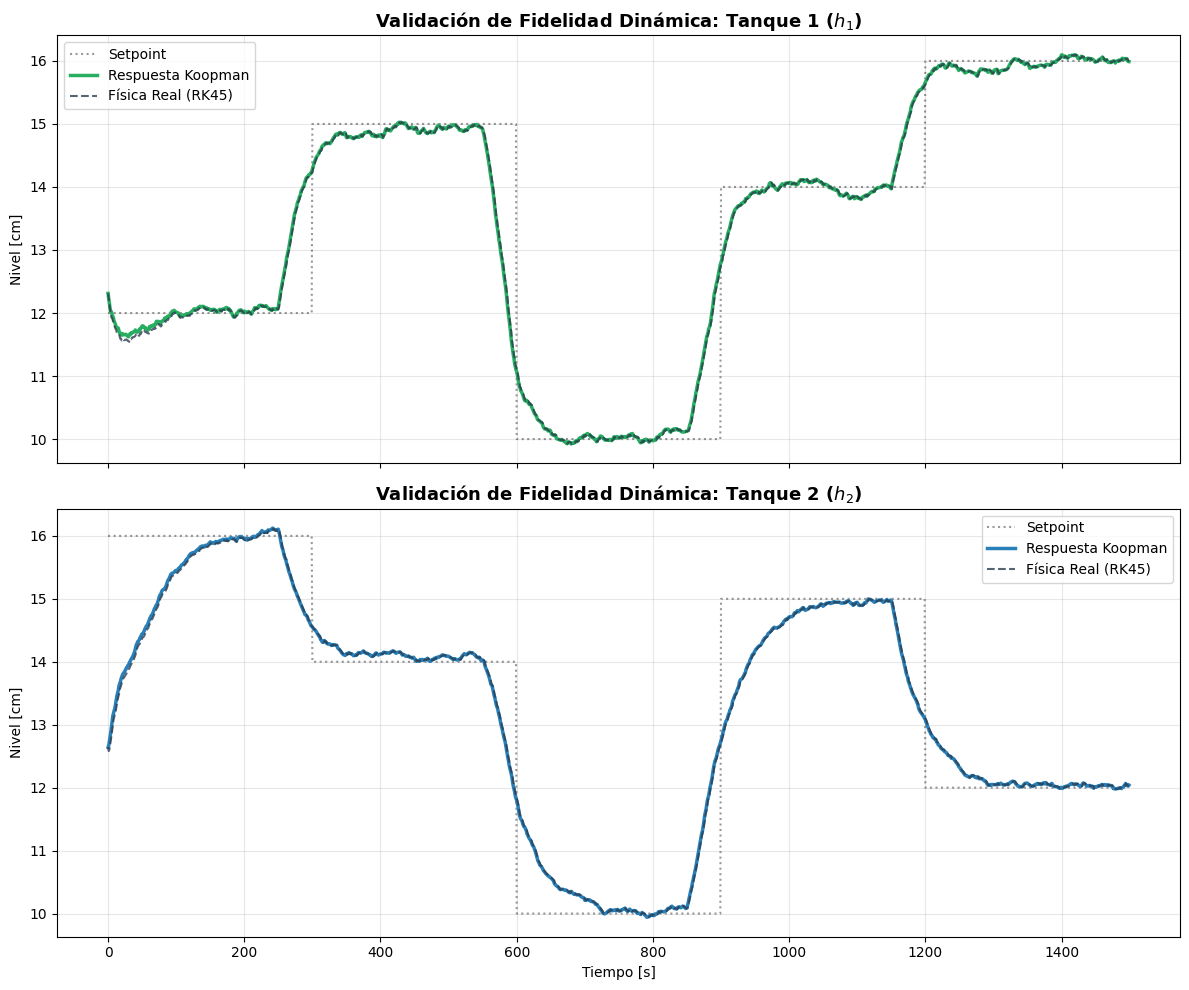


--------------------------------------------------
📊 RESULTADO DE FIDELIDAD DEL MODELO
Desviación Media (Koopman vs Física): 0.014097 cm
Precisión del Modelo: 99.8120 %
--------------------------------------------------


In [34]:
def validar_fidelidad_dinamica_koopman(history_t, history_v, history_h_koopman, history_ref, params):
    # 1. Reconstrucción de la señal de control continua para el integrador
    v1_fun = interp1d(history_t, history_v[:, 0], kind='zero', fill_value='extrapolate')
    v2_fun = interp1d(history_t, history_v[:, 1], kind='zero', fill_value='extrapolate')

    p = params

    # 2. Definición del sistema ODE real (Física de Bernoulli)
    def planta_real_val(t, h):
        h_s = np.maximum(h, 1e-6)
        v1, v2 = v1_fun(t), v2_fun(t)

        dh1 = -(p['a1']/p['A1'])*np.sqrt(2*p['g']*h_s[0]) + (p['a3']/p['A1'])*np.sqrt(2*p['g']*h_s[2]) + (p['gamma1']*p['k1']*v1)/p['A1']
        dh2 = -(p['a2']/p['A2'])*np.sqrt(2*p['g']*h_s[1]) + (p['a4']/p['A2'])*np.sqrt(2*p['g']*h_s[3]) + (p['gamma2']*p['k2']*v2)/p['A2']
        dh3 = -(p['a3']/p['A3'])*np.sqrt(2*p['g']*h_s[2]) + ((1-p['gamma2'])*p['k2']*v2)/p['A3']
        dh4 = -(p['a4']/p['A4'])*np.sqrt(2*p['g']*h_s[3]) + ((1-p['gamma1'])*p['k1']*v1)/p['A4']
        return [dh1, dh2, dh3, dh4]

    # 3. Integración de Referencia Física (Ground Truth)
    print("🔬 Calculando Ground Truth físico (RK45) para validar Koopman...")
    sol_val = solve_ivp(planta_real_val, [history_t[0], history_t[-1]], history_h_koopman[0],
                        method='RK45', t_eval=history_t, rtol=1e-8, atol=1e-8)

    h_fisica_rk45 = sol_val.y.T

    # 4. Visualización Comparativa
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Estilo visual para distinguir modelo vs realidad
    color_k1, color_k2, color_gt = '#27ae60', '#2980b9', '#2c3e50'

    # Gráfica para Tanque 1
    ax1.plot(history_t, history_ref[:, 0], 'k:', alpha=0.4, label='Setpoint')
    ax1.plot(history_t, history_h_koopman[:, 0], color=color_k1, label='Respuesta Koopman', linewidth=2.5)
    ax1.plot(history_t, h_fisica_rk45[:, 0], color=color_gt, linestyle='--', alpha=0.8, label='Física Real (RK45)')
    ax1.set_title('Validación de Fidelidad Dinámica: Tanque 1 ($h_1$)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Nivel [cm]')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Gráfica para Tanque 2
    ax2.plot(history_t, history_ref[:, 1], 'k:', alpha=0.4, label='Setpoint')
    ax2.plot(history_t, history_h_koopman[:, 1], color=color_k2, label='Respuesta Koopman', linewidth=2.5)
    ax2.plot(history_t, h_fisica_rk45[:, 1], color=color_gt, linestyle='--', alpha=0.8, label='Física Real (RK45)')
    ax2.set_title('Validación de Fidelidad Dinámica: Tanque 2 ($h_2$)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Nivel [cm]')
    ax2.set_xlabel('Tiempo [s]')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Cálculo y reporte de métricas de fidelidad
    error_modelo = np.mean(np.abs(history_h_koopman - h_fisica_rk45))
    precision = 100 * (1 - error_modelo/np.mean(h_fisica_rk45))

    print(f"\n" + "-"*50)
    print(f"📊 RESULTADO DE FIDELIDAD DEL MODELO")
    print(f"Desviación Media (Koopman vs Física): {error_modelo:.6f} cm")
    print(f"Precisión del Modelo: {precision:.4f} %")
    print(f"-"*50)

    return h_fisica_rk45

# Ejecución de la auditoría
h_fisica_full = validar_fidelidad_dinamica_koopman(history_t, history_v, history_h, history_ref, params_mpc)

## Fidelidad dinámica de los tanques inferiores: Koopman + MPC vs Simulación

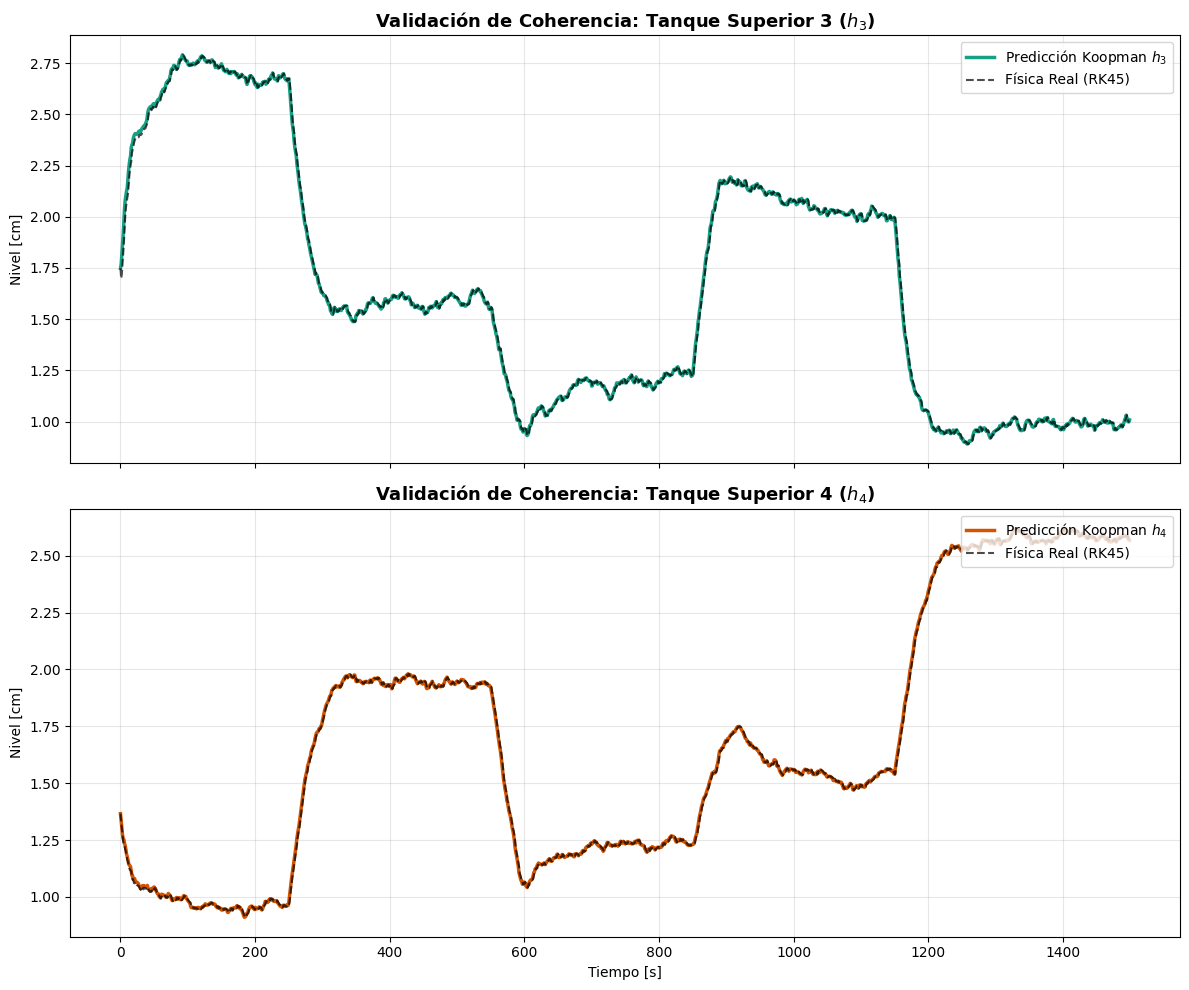


╔══════════════════════════════════════════════════════════╗
║     INFORME DE FIDELIDAD DINÁMICA: OPERADOR KOOPMAN      ║
╠══════════════════════════════════════════════════════════╣
║ Error medio h1: 0.021412 cm | VAF: 99.98%     ║
║ Error medio h2: 0.020420 cm | VAF: 99.97%     ║
║ Error medio h3: 0.008792 cm | VAF: 99.95%     ║
║ Error medio h4: 0.005765 cm | VAF: 99.98%     ║
╠══════════════════════════════════════════════════════════╣
║ FIDELIDAD GLOBAL (Basada en MAE): 99.9859%                  ║
║ PRECISIÓN DEL MODELO (Promedio VAF): 99.9690%          ║
╚══════════════════════════════════════════════════════════╝


In [35]:
def validar_fisica_superior_koopman(history_t, history_h_koopman, h_fisica_rk45):
    """
    Evalúa la fidelidad de los tanques superiores (h3, h4) y genera el
    informe final de precisión para el modelo Koopman.
    """
    fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Estética visual: Colores para diferenciar la dinámica de carga superior
    color_h3 = '#16a085'  # Verde esmeralda oscuro
    color_h4 = '#d35400'  # Naranja quemado

    # Visualización de fidelidad para el Tanque 3
    ax3.plot(history_t, history_h_koopman[:, 2], color=color_h3, label='Predicción Koopman $h_3$', linewidth=2.5)
    ax3.plot(history_t, h_fisica_rk45[:, 2], 'k--', alpha=0.7, label='Física Real (RK45)')
    ax3.set_title('Validación de Coherencia: Tanque Superior 3 ($h_3$)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Nivel [cm]')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    # Visualización de fidelidad para el Tanque 4
    ax4.plot(history_t, history_h_koopman[:, 3], color=color_h4, label='Predicción Koopman $h_4$', linewidth=2.5)
    ax4.plot(history_t, h_fisica_rk45[:, 3], 'k--', alpha=0.7, label='Física Real (RK45)')
    ax4.set_title('Validación de Coherencia: Tanque Superior 4 ($h_4$)', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Nivel [cm]')
    ax4.set_xlabel('Tiempo [s]')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- Generación del Informe Ejecutivo de Fidelidad ---
    maes = np.mean(np.abs(history_h_koopman - h_fisica_rk45), axis=0)
    global_mae = np.mean(maes)

    def calculate_vaf(y_true, y_pred):
        """Calcula el Variance Fraction entre la realidad y la predicción."""
        return max(0, (1 - np.var(y_true - y_pred) / np.var(y_true)) * 100)

    # Formateo de salida en consola para un reporte profesional
    print("\n" + "╔" + "═"*58 + "╗")
    print(f"║{'INFORME DE FIDELIDAD DINÁMICA: OPERADOR KOOPMAN':^58}║")
    print("╠" + "═"*58 + "╣")
    for i in range(4):
        vaf_val = calculate_vaf(h_fisica_rk45[:, i], history_h_koopman[:, i])
        print(f"║ Error medio h{i+1}: {maes[i]:.6f} cm | VAF: {vaf_val:.2f}%{' ':^5}║")

    avg_vaf = np.mean([calculate_vaf(h_fisica_rk45[:, i], history_h_koopman[:, i]) for i in range(4)])
    print("╠" + "═"*58 + "╣")
    print(f"║ FIDELIDAD GLOBAL (Basada en MAE): {100 - global_mae:.4f}%{' ':^18}║")
    print(f"║ PRECISIÓN DEL MODELO (Promedio VAF): {avg_vaf:.4f}%{' ':^10}║")
    print("╚" + "═"*58 + "╝")

# Ejecución del reporte final de auditoría
validar_fisica_superior_koopman(history_t, history_h, h_fisica_full)